<a href="https://colab.research.google.com/github/lopezd16/Equipo4_proyecto_integrador/blob/main/Avance3_Equipo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 3. Ingeniería de características


## Radar predictivo - Equipo 4

## Contexto

El presente proyecto tiene como objetivo aplicar técnicas de Inteligencia Artificial y Aprendizaje Automático (AI/ML) para identificar y alertar a los usuarios de lo que esta pasando en el mundo de las criptos de forma oportuna y digerida. La investigación se enfocará en el mercado latinoamericano, dado que se ha observado una creciente participación de inversionistas jóvenes en la región, quienes demandan información inmediata y relevante para respaldar sus procesos de toma de decisiones

## Introduction

Generar un modelo baseline para evaluar la viabilidad del proyecto es un paso clave en el desarrollo de soluciones, nos permite identificar oportunamente si es factible predecir u opera tizar la idea. Para esta etapa, es recomendable arrancar con un modelo simple y rápido de entrenar que nos permita itinerar de forma rápida y eficientemente.

Razones para considerar un modelo baseline:
1. Proporciona un punto de partida.
2. Permite medir la mejora real.
3. Ayuda a detectar errores o expectativas poco realistas.
4. Facilita la comunicación y la justificación de resultados.
5. Fomenta la iteración incremental


# ¿Qué estamos haciendo?

* **Ingesta**: bajamos noticias cripto (NewsAPI) y datos de mercado/categorías (CoinGecko).

* **Limpieza + Enlace:** limpiamos texto, detectamos tokens (BTC, ETH…) y los mapeamos a categorías (Bitcoin, Stablecoins, L1…). Así cada nota queda ligada a un segmento del mercado.

* **Temas (LDA):** a cada noticia le calculamos probabilidades de tema (p. ej., Regulación/ETF, Stablecoins/Pagos, Hacks…), no solo el índice.

* **Dataset integrado:** unimos noticia+tema+categoría con métricas de mercado (market cap, volumen, cambios) y creamos features (PCs, residuo volumen~MC).

-------------Phase 1 "Setup Data" ---------------------------

Este bloque fue lo que se hizo en la fase 1 del proyecto, el cual recolecta y estandariza la información que necesitamos de dos fuentes públicas. Por un lado, baja noticias recientes sobre el tema “crypto” (de ayer y antier) desde NewsAPI, priorizando las más populares; por otro, consulta en CoinGecko el ranking de criptomonedas (precio, capitalización, volumen, cambio 24h) y las categorías de mercado (por ejemplo, Layer-1, DeFi, PoW) con su top-3 de monedas. Para no depender de datos en vivo en pruebas, incluye un lote DEMO si no hay llave de NewsAPI. Todo se guarda en tres tablas limpias: df_news_clean, df_crypto_clean y df_categories.

Antes de guardar, el código hace una limpieza práctica:
1. Quita HTML y URLs de los textos (para que los títulos y descripciones sean legibles)
2. Normaliza símbolos de monedas (por ejemplo, “eth”→“ETH”)
3. Separa fecha y hora desde los sellos de tiempo ISO.
4. Aplica una transformación logarítmica a la capitalización de mercado para reducir distorsiones cuando hay valores muy grandes (esto facilita comparaciones y gráficas).

Respeta una breve pausa entre llamadas (1 segundo) para evitar límites de las APIs.

En términos de negocio, el resultado es un dataset listo para análisis: podemos cruzar “lo que se dijo” (noticias) con “lo que pasó” (precio, volumen, categorías) sin fricción.

**Ejemplo:**

Si hoy hay una nota de Reuters sobre un ETF de Bitcoin, quedará limpia y fechada en df_news_clean; al mismo tiempo, df_crypto_clean nos dice cómo se movió BTC y el volumen asociado, y df_categories permite ver si el impacto fue sectorial (p.ej., Smart Contracts o Stablecoins). Con esto, el siguiente paso —guardar en base de datos y disparar alertas/bots— es directo.

In [ ]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 14.3 MB/s eta 0:00:00


In [ ]:
import os
import re
import time
import json
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime, timezone

In [ ]:
NEWSAPI_KEY   = os.getenv("NEWSAPI_KEY", "62c474fdc3c64afeb4b41290b67b5b6f")
NEWS_QUERY    = "crypto"   #El tema en cuestión
NEWS_LANG     = "en"       # "en" o "es" depende del idioma
NEWS_PAGESIZE = 100
NEWS_SORT     = "popularity"   # relevancy|popularity|publishedAt
BASE_TODAY = date.today() - timedelta(days=1) #Se obtiene información de la fecha de ayer y antier
NEWS_FROM     = (BASE_TODAY - timedelta(days=1)).strftime("%Y-%m-%d")            # ej. "2025-08-31"
NEWS_TO       = BASE_TODAY.strftime("%Y-%m-%d")              # ej. "2025-09-01"

COINGECKO_MARKETS_URL    = "https://api.coingecko.com/api/v3/coins/markets"
COINGECKO_CATEGORIES_URL = "https://api.coingecko.com/api/v3/coins/categories"
VS_CURRENCY       = "usd"
MARKETS_PER_PAGE  = 100
MARKETS_PAGES     = 1

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#---------------------------------------------------------------------------

URL_PATTERN      = re.compile(r"http\S+|www\.\S+")
HTML_TAG_PATTERN = re.compile(r"<.*?>")

def clean_text(txt: str) -> str:
    """
    Limpieza de texto para noticias:
      - Quita HTML y URLs.
      - Conserva caracteres alfanuméricos básicos, acentos y puntuación simple.
      - Normaliza espacios.
    """
    if not isinstance(txt, str):
        return ""
    txt = re.sub(HTML_TAG_PATTERN, " ", txt)
    txt = re.sub(URL_PATTERN, " ", txt)
    txt = re.sub(r"[^A-Za-z0-9ÁÉÍÓÚáéíóúñÑ .,!?()\-:;%/]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def normalize_symbol(sym: str, max_len: int = 5) -> str:
    """
    Normaliza el símbolo de la cripto:
      - Solo letras (sin números/guiones).
      - Mayúsculas.
      - Longitud máxima = 5 (ej. BTC, ETH, SOL).
    """
    if not isinstance(sym, str):
        return ""
    sym = re.sub(r"[^A-Za-z]", "", sym).upper()
    return sym[:max_len]

def split_datetime_iso8601(ts: str):
    """
    Convierte una marca de tiempo ISO8601 a:
      (fecha_dd/mm/yyyy, hora_HH:MM:SS).
    Soporta sufijo 'Z' y offsets.
    """
    if not isinstance(ts, str) or not ts:
        return "", ""
    try:
        dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        return dt.strftime("%d/%m/%Y"), dt.strftime("%H:%M:%S")
    except Exception:
        return "", ""

#---------------------------------------------------------------------

def fetch_newsapi(query=NEWS_QUERY, language=NEWS_LANG, pagesize=NEWS_PAGESIZE,
                  sortby=NEWS_SORT, api_key=NEWSAPI_KEY, from_date=NEWS_FROM, to_date=NEWS_TO, page=1):
    """
    Descarga noticias desde NewsAPI. Si no hay API key, devuelve un lote DEMO.
    """
    if not api_key:
        return {
            "status": "ok",
            "totalResults": 3,
            "articles": [
                {
                    "source": {"id": "business-insider", "name": "Business Insider"},
                    "author": "Henry Chandonnet",
                    "title": "Marc Benioff on AGI 'hypnosis' – what it means for crypto markets",
                    "description": "Salesforce CEO doubts AGI hype. <b>Markets react</b>. Read more at https://example.com ...",
                    "url": "https://www.businessinsider.com/marc-benioff-extremely-suspect-agi-hypnosis-2025-8",
                    "urlToImage": "https://i.insider.com/img.jpg",
                    "publishedAt": "2025-08-28T18:12:29Z",
                    "content": "AGI hype & crypto: visit https://foo.bar for details. <ul><li>BTC up?</li></ul>"
                },
                {
                    "source": {"id": None, "name": "Reuters"},
                    "author": None,
                    "title": "ETF Bitcoin receives approval; volatility ahead?",
                    "description": "Regulators approve ETF. Markets brace for swings.",
                    "url": "https://www.reuters.com/markets/bitcoin-etf-approved-2025-08-28/",
                    "urlToImage": None,
                    "publishedAt": "2025-08-28T09:00:02Z",
                    "content": "Analysts expect higher inflows. Read at http://reuters.com/article?id=xyz."
                },
                {
                    "source": {"id": "ft", "name": "Financial Times"},
                    "author": "FT Staff",
                    "title": "DeFi growth accelerates in Latin America 🚀",
                    "description": "TVL climbs 15% this week; key protocols show strength.",
                    "url": "https://www.ft.com/content/defi-growth-latam",
                    "urlToImage": "https://www.ft.com/img.jpg",
                    "publishedAt": "2025-08-29T01:20:00Z",
                    "content": "DeFi momentum across ETH, SOL. <a href='https://ft.com/defi'>link</a>"
                },
            ]
        }
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": language,
        "pageSize": pagesize,
        "sortBy": sortby,
        "apiKey": api_key,
        "page": page
    }
    if from_date: params["from"] = from_date
    if to_date:   params["to"]   = to_date
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_markets(vs_currency=VS_CURRENCY, per_page=MARKETS_PER_PAGE, page=1):
    """
    Descarga el ranking de criptomonedas por market cap (hasta 'per_page' por página).
    """
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": per_page,
        "page": page,
        "sparkline": "false"
    }
    r = requests.get(COINGECKO_MARKETS_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_categories():
    """
    Descarga categorías (Layer1, DeFi, PoW, etc.) con market cap y top 3 coins por categoría.
    """
    r = requests.get(COINGECKO_CATEGORIES_URL, timeout=30)
    r.raise_for_status()
    return r.json()

# Ejecutar las 3 descargas********************************************************************************************************
# ================================
# 🔁 Descarga noticias de 3 días consecutivos (prioridad: más recientes)
# ================================
BASE_TODAY = date.today()  - timedelta(days=1)
news_frames = []

for delta in range(1, 4):  # 1=ayer, 2=antier, 3=hace tres días
    target_date = (BASE_TODAY - timedelta(days=delta)).strftime("%Y-%m-%d")
    output_path = os.path.join(OUTPUT_DIR, f"news_{target_date}.csv")

    # Si ya existe el CSV, lo carga (ahorra peticiones)
    if os.path.exists(output_path):
        print(f"📂 Ya existe archivo para {target_date}, cargando desde disco...")
        df_day = pd.read_csv(output_path)
    else:
        print(f"📰 Descargando noticias de {target_date}...")
        data = fetch_newsapi(
            query=NEWS_QUERY, language=NEWS_LANG,
            pagesize=NEWS_PAGESIZE, sortby=NEWS_SORT,
            api_key=NEWSAPI_KEY,
            from_date=target_date, to_date=target_date
        )
        df_day = pd.DataFrame(data.get("articles", []))
        if not df_day.empty:
            df_day["fecha"] = target_date
            df_day.to_csv(output_path, index=False)
            print(f"✅ Guardadas {len(df_day)} noticias en {output_path}")
        else:
            print(f"⚠️ No se obtuvieron noticias para {target_date}")

    if not df_day.empty:
        news_frames.append(df_day)

# Combina todos los días descargados y conserva estructura original
if news_frames:
    df_news = pd.concat(news_frames, ignore_index=True)
    news_raw = {"status": "ok", "articles": df_news.to_dict(orient="records")}  # ← mantiene news_raw
    print(f"\n📆 Total combinado: {len(df_news)} noticias de {df_news['fecha'].nunique()} días distintos.")
else:
    print("❌ No se descargaron noticias.")
    news_raw = {"status": "error", "articles": []}

# ********************************************************************************************************************************
mkts_raw = []
for p in range(1, MARKETS_PAGES + 1):
    mkts_raw.extend(fetch_coingecko_markets(page=p))
    time.sleep(1)  # cortesía para evitar rate limiting
cats_raw = fetch_coingecko_categories()

#---------------------------------------------------------------------------

# --- Noticias ---
df_news = pd.DataFrame(news_raw.get("articles", []))

# Aplanamos la fuente: dict -> string
if "source" in df_news.columns:
    df_news["source_name"] = df_news["source"].apply(lambda s: s.get("name") if isinstance(s, dict) else None)

# Limpieza de textos (title, description, content)
for col in ["title", "description", "content"]:
    df_news[col + "_clean"] = df_news[col].apply(clean_text)

# Autor nulo -> "Desconocido"
df_news["author"] = df_news["author"].fillna("Desconocido")

# Separar fecha/hora (ISO8601 -> dd/mm/yyyy + HH:MM:SS)
df_news[["fecha", "hora"]] = df_news["publishedAt"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

# Selección/renombrado de columnas finales
df_news_clean = df_news[[
    "source_name", "author", "title_clean", "description_clean", "content_clean", "fecha", "hora", "url"
]].rename(columns={
    "source_name": "fuente",
    "title_clean": "titulo",
    "description_clean": "descripcion",
    "content_clean": "contenido"
})

# --- Mercados (CoinGecko) ---
df_markets = pd.DataFrame(mkts_raw)

if not df_markets.empty:
    # Normalizar símbolo
    df_markets["symbol"] = df_markets["symbol"].apply(normalize_symbol)
    # Transformación logarítmica para market_cap (reduce dispersión)
    if "market_cap" in df_markets.columns:
        df_markets["log_market_cap"] = np.log1p(df_markets["market_cap"].astype(float))
    # Separar fecha/hora
    if "last_updated" in df_markets.columns:
        df_markets[["fecha", "hora"]] = df_markets["last_updated"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

df_crypto_clean = df_markets[[
    "id","name","symbol","current_price","market_cap","total_volume",
    "price_change_percentage_24h","log_market_cap","fecha","hora"
]].rename(columns={"name":"asset"})

# --- Categorías (CoinGecko) ---
df_categories = pd.DataFrame(cats_raw)
sel_cols = ["id","name","market_cap","market_cap_change_24h","volume_24h","top_3_coins_id","updated_at"]
df_categories = df_categories[[c for c in sel_cols if c in df_categories.columns]]

if "updated_at" in df_categories.columns:
    df_categories[["fecha","hora"]] = df_categories["updated_at"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))
    df_categories = df_categories.drop(columns=["updated_at"])

df_categories = df_categories.rename(columns={"name":"category"})

#-------------------------------------------------------------------------------



📰 Descargando noticias de 2025-10-11...
✅ Guardadas 100 noticias en outputs/news_2025-10-11.csv
📰 Descargando noticias de 2025-10-10...
✅ Guardadas 100 noticias en outputs/news_2025-10-10.csv
📰 Descargando noticias de 2025-10-09...
✅ Guardadas 100 noticias en outputs/news_2025-10-09.csv

📆 Total combinado: 300 noticias de 3 días distintos.


In [ ]:
df_news_clean.head()

,fuente,author,titulo,descripcion,contenido,fecha,hora,url
0,BeInCrypto,Oluwapelumi Adejumo,This Crypto Trader Made 160 Million Profit Dur...,A crypto whale made over 160 million in just 3...,"Bitcoin buy, bitcoin risk, bitcoin bear market...",11/10/2025,09:09:33,https://beincrypto.com/crypto-whale-makes-mill...
1,ABC News,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,A woman in rural West Texas says she was caugh...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,18:25:10,https://abcnews.go.com/US/video/farmer-finds-n...
2,ABC News,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",Jared Kushner and Ivanka Trump addressed a cro...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,19:30:30,https://abcnews.go.com/International/video/jar...
3,Boredpanda.com,Ilona Baliūnaitė,"Educated Person Falls For Scam Investment, Sur...",How can a couple stay married after such a fia...,Money is one of the many touchy issues among m...,11/10/2025,01:00:33,https://www.boredpanda.com/pig-slaughtering-sc...
4,Nakedcapitalism.com,Yves Smith,Links 10/11/2025,Our lightening daily links: Ig Noble pasta tri...,Surprise: Fog in March. Louis enjoys his morni...,11/10/2025,10:55:57,https://www.nakedcapitalism.com/2025/10/links-...


In [ ]:
df_crypto_clean.head(15)

,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora
0,bitcoin,Bitcoin,BTC,115202.000000,2291250459189,9.462220e+10,4.30763,28.460119,13/10/2025,00:14:56
1,ethereum,Ethereum,ETH,4143.090000,500113032568,5.795493e+10,10.87628,26.938100,13/10/2025,00:14:56
2,binancecoin,BNB,BNB,1311.450000,181185013608,9.176052e+09,15.80173,25.922785,13/10/2025,00:14:56
3,tether,Tether,USDT,1.001000,180013867666,1.782431e+11,-0.03299,25.916300,13/10/2025,00:14:58
4,ripple,XRP,XRP,2.520000,151584416248,9.599643e+09,6.00944,25.744409,13/10/2025,00:14:56
5,solana,Solana,SOL,196.700000,107566172779,1.217178e+10,11.34100,25.401372,13/10/2025,00:14:56
6,usd-coin,USDC,USDC,0.999905,75637870680,1.696759e+10,0.00004,25.049223,13/10/2025,00:14:58
7,staked-ether,Lido Staked Ether,STETH,4139.790000,35201432381,1.046417e+08,10.81630,24.284353,13/10/2025,00:14:56
8,dogecoin,Dogecoin,DOGE,0.206529,31356692376,4.891121e+09,11.67801,24.168694,13/10/2025,00:14:51
9,tron,TRON,TRX,0.322797,30577330398,1.000974e+09,2.80952,24.143525,13/10/2025,00:14:57


In [ ]:
df_categories.head(15)

,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora
0,smart-contract-platform,Smart Contract Platform,3.352685e+12,6.044321,1.990706e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:11:42
1,layer-1,Layer 1 (L1),3.273654e+12,5.844190,1.906298e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:10:51
2,proof-of-work-pow,Proof of Work (PoW),2.364722e+12,4.067001,1.032720e+11,"[bitcoin, dogecoin, bitcoin-cash]",13/10/2025,00:10:14
3,proof-of-stake-pos,Proof of Stake (PoS),9.108765e+11,11.055533,8.973736e+10,"[ethereum, binancecoin, solana]",13/10/2025,00:11:48
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.466049e+11,7.118330,2.596886e+11,"[ethereum, tether, usd-coin]",13/10/2025,00:11:54
5,made-in-usa,Made in USA,5.031557e+11,6.992995,5.682881e+10,"[ripple, solana, usd-coin]",13/10/2025,00:11:50
6,alleged-sec-securities,Alleged SEC Securities,3.661053e+11,11.865308,2.616124e+10,"[binancecoin, solana, tron]",13/10/2025,00:10:29
7,stablecoins,Stablecoins,3.103503e+11,0.338547,2.057128e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:10:35
8,usd-stablecoin,USD Stablecoin,3.026740e+11,0.340165,2.049500e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:10:38
9,fiat-backed-stablecoin,Fiat-backed Stablecoin,2.975893e+11,0.407931,2.041368e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:11:47


-------------Phase 1 "Setup Data" ---------------------------


# 📙 Crypto News × Markets — Feature Engineering Notebook

Este notebook implementa la fase de **Preparación de los Datos / Feature Engineering (CRISP‑ML)** sobre tres DataFrames esperados:
- `df_categories`: categorías de mercado y métricas agregadas por categoría.
- `df_news_clean`: noticias procesadas (título, descripción, contenido, fuente, fecha, hora, url, …).
- `df_crypto_clean`: snapshot de mercado por criptoactivo (precio, market cap, volumen, ATH/ATL, etc.).

**Objetivo:** habilitar un dataset integrado que conecte **temas de noticias** con **categorías** y **tendencias de mercado** para análisis en tiempo real.


In [ ]:

# ============================================================
# 0) Setup: imports y utilidades
# ============================================================
import re
import ast
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, chi2, SelectKBest, f_classif
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['axes.grid'] = False

def sec(t):
    print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))



## 1) Carga de datos (placeholders)
Este notebook utiliza los data frames generados en la fase 1, `df_categories`, `df_news_clean`, `df_crypto_clean`.


In [ ]:
# Validación rápida
for name in ['df_categories','df_news_clean','df_crypto_clean']:
    if name not in globals():
        print(f"⚠️ Aviso: {name} no está en memoria. Cárgalo o créalo antes de continuar.")
    else:
        print(f"✔ {name} disponible: {eval(name).shape}")


✔ df_categories disponible: (622, 8)
✔ df_news_clean disponible: (300, 8)
✔ df_crypto_clean disponible: (100, 10)



## 2) Armonización mínima de esquemas
- Conversión de tipos y parseo de columnas específicas.
- Creación de llaves auxiliares para enlaces (`id`, `symbol`, …).


In [ ]:

sec("Armonización de df_categories")
if 'df_categories' in globals():
    cat = df_categories.copy()

    # Asegurar que 'top_3_coins_id' sea lista
    if 'top_3_coins_id' in cat.columns:
        def to_list(x):
            if isinstance(x, list):
                return x
            if pd.isna(x):
                return []
            # algunos vienen como cadena tipo "['btc','eth']"
            try:
                val = ast.literal_eval(str(x))
                if isinstance(val, list):
                    return val
            except:
                pass
            # si viene como "bitcoin, ethereum, binancecoin"
            return [t.strip() for t in str(x).strip('[]').split(',') if str(t).strip()]
        cat['top_3_coins_id'] = cat['top_3_coins_id'].apply(to_list)

    # Normalización de fecha/hora si existen
    if 'fecha' in cat.columns:
        # df_categories trae fecha en formato dd/mm/YYYY
        cat['fecha_dt'] = pd.to_datetime(cat['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in cat.columns:
        cat['hora_s'] = cat['hora'].astype(str)

    display(cat.head())
else:
    cat = None



Armonización de df_categories


,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s
0,smart-contract-platform,Smart Contract Platform,3.352685e+12,6.044321,1.990706e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:11:42,2025-10-13,00:11:42
1,layer-1,Layer 1 (L1),3.273654e+12,5.844190,1.906298e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:10:51,2025-10-13,00:10:51
2,proof-of-work-pow,Proof of Work (PoW),2.364722e+12,4.067001,1.032720e+11,"[bitcoin, dogecoin, bitcoin-cash]",13/10/2025,00:10:14,2025-10-13,00:10:14
3,proof-of-stake-pos,Proof of Stake (PoS),9.108765e+11,11.055533,8.973736e+10,"[ethereum, binancecoin, solana]",13/10/2025,00:11:48,2025-10-13,00:11:48
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.466049e+11,7.118330,2.596886e+11,"[ethereum, tether, usd-coin]",13/10/2025,00:11:54,2025-10-13,00:11:54


In [ ]:

sec("Armonización de df_crypto_clean")
if 'df_crypto_clean' in globals():
    mkt = df_crypto_clean.copy()

    # Fechas
    for c in ['ath_date','atl_date','last_updated']:
        if c in mkt.columns:
            mkt[c] = pd.to_datetime(mkt[c], errors='coerce')

    # Fecha/hora local (si existen columnas texto)
    if 'fecha' in mkt.columns:
        mkt['fecha_dt'] = pd.to_datetime(mkt['fecha'], dayfirst=True, errors='coerce')
    if 'hora' in mkt.columns:
        mkt['hora_s'] = mkt['hora'].astype(str)

    # Log transform ya disponible como 'log_market_cap' en tu muestra; lo recalculamos por si falta.
    if 'market_cap' in mkt.columns and 'log_market_cap' not in mkt.columns:
        mkt['log_market_cap'] = np.log1p(mkt['market_cap'].astype(float))

    # Volatilidad diaria si existen máximos/mínimos
    if {'high_24h','low_24h'}.issubset(mkt.columns):
        mkt['volatility_ratio'] = mkt.apply(
            lambda r: (r['high_24h'] / r['low_24h']) if (pd.notna(r.get('high_24h')) and pd.notna(r.get('low_24h')) and r.get('low_24h',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Liquidez proxy
    if {'total_volume','market_cap'}.issubset(mkt.columns):
        mkt['turnover_ratio'] = mkt.apply(
            lambda r: (r['total_volume'] / r['market_cap']) if (pd.notna(r.get('total_volume')) and pd.notna(r.get('market_cap')) and r.get('market_cap',0) not in [0,np.nan]) else np.nan,
            axis=1
        )

    # Días desde ATH/ATL
    today = pd.Timestamp.utcnow().normalize()
    if 'ath_date' in mkt.columns:
        mkt['days_since_ath'] = (today - mkt['ath_date']).dt.days
    if 'atl_date' in mkt.columns:
        mkt['days_since_atl'] = (today - mkt['atl_date']).dt.days

    display(mkt.head())
else:
    mkt = None



Armonización de df_crypto_clean


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio
0,bitcoin,Bitcoin,BTC,115202.000,2291250459189,9.462220e+10,4.30763,28.460119,13/10/2025,00:14:56,2025-10-13,00:14:56,0.041297
1,ethereum,Ethereum,ETH,4143.090,500113032568,5.795493e+10,10.87628,26.938100,13/10/2025,00:14:56,2025-10-13,00:14:56,0.115884
2,binancecoin,BNB,BNB,1311.450,181185013608,9.176052e+09,15.80173,25.922785,13/10/2025,00:14:56,2025-10-13,00:14:56,0.050645
3,tether,Tether,USDT,1.001,180013867666,1.782431e+11,-0.03299,25.916300,13/10/2025,00:14:58,2025-10-13,00:14:58,0.990163
4,ripple,XRP,XRP,2.520,151584416248,9.599643e+09,6.00944,25.744409,13/10/2025,00:14:56,2025-10-13,00:14:56,0.063329


In [ ]:
print(sorted(mkt.columns))

['asset', 'current_price', 'fecha', 'fecha_dt', 'hora', 'hora_s', 'id', 'log_market_cap', 'market_cap', 'price_change_percentage_24h', 'symbol', 'total_volume', 'turnover_ratio']


In [ ]:

sec("Armonización de df_news_clean")
if 'df_news_clean' in globals():
    news = df_news_clean.copy()

    # Fecha/hora
    for c in ['fecha','hora']:
        if c in news.columns:
            news[c] = news[c].astype(str)

    # Construcción de texto unificado
    text_cols = [c for c in ['titulo','descripcion','contenido'] if c in news.columns]
    if text_cols:
        news['text_full'] = news[text_cols].fillna('').agg(' '.join, axis=1).str.strip()
    else:
        news['text_full'] = ''

    # Longitudes simples
    news['n_chars'] = news['text_full'].str.len()
    news['n_words'] = news['text_full'].str.split().apply(len)

    display(news.head())
else:
    news = None



Armonización de df_news_clean


,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,n_words
0,BeInCrypto,Oluwapelumi Adejumo,This Crypto Trader Made 160 Million Profit Dur...,A crypto whale made over 160 million in just 3...,"Bitcoin buy, bitcoin risk, bitcoin bear market...",11/10/2025,09:09:33,https://beincrypto.com/crypto-whale-makes-mill...,This Crypto Trader Made 160 Million Profit Dur...,402,65
1,ABC News,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,A woman in rural West Texas says she was caugh...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,18:25:10,https://abcnews.go.com/US/video/farmer-finds-n...,WATCH: Farmer finds NASA equipment in neighbor...,399,66
2,ABC News,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",Jared Kushner and Ivanka Trump addressed a cro...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,19:30:30,https://abcnews.go.com/International/video/jar...,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",395,61
3,Boredpanda.com,Ilona Baliūnaitė,"Educated Person Falls For Scam Investment, Sur...",How can a couple stay married after such a fia...,Money is one of the many touchy issues among m...,11/10/2025,01:00:33,https://www.boredpanda.com/pig-slaughtering-sc...,"Educated Person Falls For Scam Investment, Sur...",355,59
4,Nakedcapitalism.com,Yves Smith,Links 10/11/2025,Our lightening daily links: Ig Noble pasta tri...,Surprise: Fog in March. Louis enjoys his morni...,11/10/2025,10:55:57,https://www.nakedcapitalism.com/2025/10/links-...,Links 10/11/2025 Our lightening daily links: I...,484,75



## 3) Enlace **categorías ↔ mercados** y asignación aproximada de **categorías ↔ noticias**
- De `df_categories` extraemos un **mapa coin → categorías** usando `top_3_coins_id`.
- De `df_crypto_clean` extraemos **id y symbol** para detección de menciones en las noticias.
- En `df_news_clean`, detectamos menciones de *coin ids/símbolos* en `text_full` y asignamos **categoría primaria** (heurística).


Este bloque construye un **“diccionario”** que conecta **monedas** → **categorías** a partir de la *lista top_3_coins_id* de cada categoría (por ejemplo, bitcoin y ethereum dentro de Smart Contract Platform). En paralelo reúne todos los identificadores y símbolos disponibles (p. ej., bitcoin, btc, ethereum, eth) para tener un catálogo de términos que luego buscará dentro del texto de las noticias. Con eso se imprimen ejemplos del mapa y cuántos tokens distintos se podrán detectar.

Luego, sobre cada noticia, el código detecta menciones de tokens (con una búsqueda de palabra completa y priorizando los más largos para evitar confusiones, como sol vs solana) y asigna una categoría primaria en función de esa mención: primero intenta por id (si el token ya es un id como bitcoin), y si no, traduce el símbolo → id usando el mercado (por ejemplo, ETH → ethereum) para recuperar su categoría (p. ej., Smart Contract Platform). El resultado es una primera etiqueta temática por nota, útil para cruzar “de qué se habló” con “qué segmento del mercado podría verse afectado”.

Ejemplos sencillos

* **“SEC approves ETH ETF”** → token: ETH → id: ethereum → categoría: Smart Contract Platform (según df_categories).

* **“BTC hits new high”** → token: BTC → id: bitcoin → categoría: Layer 1 / Bitcoin Ecosystem (según df_categories).

* **“Dogecoin tips surge”**→ token: DOGE → id: dogecoin → categoría: Memecoins (si existe en df_categories).

* “**Sol sube” vs “Solana sube**”: el regex y el orden por longitud prefieren “solana” y reducen falsos positivos de “sol”.

In [ ]:
# =========================
# 3) Enlace cat↔mkt y asignación aproximada de categorías ↔ noticias (falsos positivos ↓)
# =========================
sec("3) Enlace categorías ↔ mercados y asignación aproximada de categorías ↔ noticias")

import re, unicodedata, pandas as pd

def norm_txt(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower().replace("’","'").replace("–","-").replace("—","-")
    s = unicodedata.normalize("NFKD", s)
    return "".join(ch for ch in s if not unicodedata.combining(ch))

def _parse_ids(x):
    if isinstance(x, list):
        return [str(t).strip().lower() for t in x]
    x = str(x).replace('[','').replace(']','').replace("'",'').replace('"','')
    return [t.strip().lower() for t in x.split(',') if t.strip()]

# ---- columnas dinámicas detectadas ----
name_col = 'asset' if ('asset' in mkt.columns) else ('name' if 'name' in mkt.columns else None)
top_col  = 'top_3_coins_id' if 'top_3_coins_id' in cat.columns else ('top_coins' if 'top_coins' in cat.columns else None)

# ---------- 1) coin_to_cats (id/symbol/(asset|name) -> category) ----------
coin_to_cats = {}
cat_ids = None
if {'category'}.issubset(cat.columns) and top_col is not None:
    cat_ids = (
        cat[['category', top_col]].dropna(subset=[top_col])
        .assign(coin_id=lambda d: d[top_col].apply(_parse_ids))
        .explode('coin_id').dropna(subset=['coin_id'])
        .rename(columns={'coin_id':'id'})
    )
    cat_ids['id'] = cat_ids['id'].astype(str).str.lower()

mm = None
req = {'id','symbol'} | ({name_col} if name_col else set())
if req.issubset(mkt.columns):
    mm = (mkt[list(req)].dropna()
          .assign(id=lambda d: d['id'].astype(str).str.lower(),
                  symbol=lambda d: d['symbol'].astype(str).str.lower()))
    if name_col:
        mm[name_col] = mm[name_col].astype(str).str.lower()

if cat_ids is not None and len(cat_ids):
    if mm is not None and len(mm):
        j = cat_ids.merge(mm, on='id', how='left')
        for _, r in j.iterrows():
            c = r['category']
            for key in filter(None, [r.get('id'), r.get('symbol'), r.get(name_col)]):
                if isinstance(key, str) and key:
                    coin_to_cats[key] = [c]
    else:
        for _, r in cat_ids.iterrows():
            coin_to_cats[r['id']] = [r['category']]

# ---------- 2) vocabulario para regex: SOLO id+symbol (seguros) ----------
coin_symbols = []
if mm is not None and len(mm):
    for _, r in mm.iterrows():
        for v in [r['id'], r['symbol']]:
            if v and (len(v) >= 3 or v in {"btc","eth","bnb","xrp","ada","doge"}):
                coin_symbols.append(v)
else:
    coin_symbols = [k for k in coin_to_cats.keys() if k not in {'asset','name'}]

coin_symbols = sorted(set(coin_symbols), key=len, reverse=True)

# Mapa token -> canónico (usar asset/name si existe, si no id)
tok2canon = {}
if mm is not None and len(mm):
    for _, r in mm.iterrows():
        canonical = (r[name_col] if name_col else r['id'])
        for k in [r['symbol'], r['id']]:
            tok2canon[k] = canonical
        if name_col and r[name_col]:
            tok2canon[r[name_col]] = canonical  # se usará solo para cashtag/hashtag o whitelist
else:
    for k in coin_symbols: tok2canon[k] = k

# ---------- 3) detectores ----------
pat = r"(?<![a-z0-9])(" + "|".join(re.escape(t) for t in coin_symbols) + r")(?:'s)?(?![a-z0-9])"
token_regex = re.compile(pat, flags=re.IGNORECASE)
cashtag_re = re.compile(r"\$([A-Z]{2,10})")
hashtag_re = re.compile(r"#([a-z0-9_]{2,30})")

# Nombres comunes que NO queremos como match por texto plano
COMMON_WORD_STOP = {"story","base","optimism","near","ton","flow","aptos","saga"}  # ajusta a tu universo
# Frases-whitelist para permitir ciertos nombres (ej. story protocol)
NAME_WHITELIST_PHRASES = {
    "story": ["story protocol"],
    "base":  ["coinbase base","base chain"],  # evita confundir “base” genérico
    "optimism": ["optimism l2","optimism chain"]
}

def name_allowed(text, hit):
    """Permite nombres ambiguos solo si hay señales claras (frases whitelist o cashtag/hashtag)."""
    t = norm_txt(text)
    h = hit.lower()
    if h not in COMMON_WORD_STOP:
        return True
    # whitelist por frase
    for phrase in NAME_WHITELIST_PHRASES.get(h, []):
        if phrase in t:
            return True
    return False

def detect_token(text):
    if not isinstance(text, str) or not text:
        return None
    # 1) regex con id+symbol (robusto)
    t = norm_txt(text)
    m = token_regex.search(t)
    if m:
        hit = m.group(1).lower()
        return tok2canon.get(hit, hit)
    # 2) cashtags/hashtags → symbol/name permitidos
    for sym in cashtag_re.findall(text):
        hit = sym.lower()
        if hit in tok2canon:
            return tok2canon[hit]
    for tag in hashtag_re.findall(text):
        hit = tag.lower().lstrip("_")
        if hit in tok2canon:
            return tok2canon[hit]
    # 3) names ambiguos: solo si pasan whitelist (NO se incluyen en regex general)
    if name_col and mm is not None and len(mm):
        # busca nombres que estén en tok2canon y que no sean symbol/id
        for nm in mm[name_col].unique().tolist():
            if nm in tok2canon and nm not in coin_symbols:  # es un "name" no usado en regex
                if re.search(r"(?<![a-z0-9])"+re.escape(nm)+r"(?![a-z0-9])", t) and name_allowed(text, nm):
                    return tok2canon[nm]
    return None

# ---------- 4) mapeo a categoría ----------
def map_token_to_category(tok):
    if tok is None: return None
    key = str(tok).lower()
    if key in coin_to_cats and coin_to_cats[key]:
        return coin_to_cats[key][0]
    if mm is not None and len(mm):
        # resolver symbol/name -> id -> categoría
        hit = mm.loc[(mm['symbol']==key) | ((name_col and mm[name_col]==key)), 'id']
        if not hit.empty:
            cid = hit.iloc[0]
            return coin_to_cats.get(cid, [None])[0]
    return None

# ---------- 5) aplicar sobre news ----------
if 'text_full' in news.columns:
    base = news['text_full'].fillna("")
else:
    cols = [c for c in ['titulo','descripcion','contenido'] if c in news.columns]
    base = news[cols].fillna("").agg(" ".join, axis=1) if cols else pd.Series([""]*len(news), index=news.index)

news['token_mention'] = base.apply(detect_token)
news['primary_category_by_mention'] = news['token_mention'].apply(map_token_to_category)

# ---------- 6) fallback semántico más estricto ----------
ANCHORS = {"crypto","blockchain","token","coin","defi","nft","dao","exchange","wallet","staking","mining","etf","stablecoin","airdrop","protocol","onchain"}

def build_cat_keywords():
    kws = {}
    if top_col and {'category', top_col}.issubset(cat.columns):
        tmp = cat[['category', top_col]].dropna(subset=[top_col]).assign(ids=lambda d: d[top_col].apply(_parse_ids))
        for _, r in tmp.iterrows():
            c = r['category']
            kws.setdefault(c, set()).update(r['ids'])
            if mm is not None and len(mm):
                rows = mm[mm['id'].isin(r['ids'])]
                kws[c].update(rows['symbol'].tolist())
                if name_col: kws[c].update(rows[name_col].tolist())
    # enriquecer (opcional)
    kws.setdefault("Stablecoins", set()).update(["stablecoin","usdt","tether","usdc","fdusd"])
    kws.setdefault("Layer2", set()).update(["layer 2","layer-2","rollup","optimistic rollup","zk-rollup","l2","arbitrum","optimism","base"])
    kws.setdefault("DeFi", set()).update(["defi","dex","amm","yield farming","liquidity pool","uniswap","aave","curve"])
    return kws

cat_keywords = build_cat_keywords()

def fallback_category(text):
    if not isinstance(text, str) or not text:
        return None
    t = norm_txt(text)
    # requiere al menos 1 ancla cripto
    if not any(re.search(r"(?<![a-z0-9])"+re.escape(a)+r"(?![a-z0-9])", t) for a in ANCHORS):
        return None
    # busca keywords por categoría
    for c, kws in cat_keywords.items():
        for kw in kws:
            kw = str(kw).lower()
            if re.search(r"(?<![a-z0-9])"+re.escape(kw)+r"(?![a-z0-9])", t):
                return c
    return None

mask_none = news['primary_category_by_mention'].isna()
news.loc[mask_none, 'primary_category_by_mention'] = base[mask_none].apply(fallback_category)

# ---------- 7) salida ----------
display(news[['fuente','titulo','token_mention','primary_category_by_mention']].head(20))



3) Enlace categorías ↔ mercados y asignación aproximada de categorías ↔ noticias


,fuente,titulo,token_mention,primary_category_by_mention
0,BeInCrypto,This Crypto Trader Made 160 Million Profit Dur...,official trump,PolitiFi
1,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,None,None
2,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",official trump,PolitiFi
3,Boredpanda.com,"Educated Person Falls For Scam Investment, Sur...",None,None
4,Nakedcapitalism.com,Links 10/11/2025,official trump,PolitiFi
5,Forbes,State Backed Hackers Reinforce The Need For Be...,None,None
6,Forbes,Did Trump s Tariff Trigger A Crypto Purge Or J...,official trump,PolitiFi
7,Forbes,Trump Surprise Triggers Huge Crypto Flash Cras...,official trump,PolitiFi
8,Forbes,"Ether Prices Plunge 20% To 3,500 As Tariff Fea...",None,None
9,Line25.com,1win Ci En C te D ivoire Site Officiel De Rome...,None,None


In [ ]:
display(news.head(10))

,fuente,author,titulo,descripcion,contenido,fecha,hora,url,text_full,n_chars,n_words,token_mention,primary_category_by_mention
0,BeInCrypto,Oluwapelumi Adejumo,This Crypto Trader Made 160 Million Profit Dur...,A crypto whale made over 160 million in just 3...,"Bitcoin buy, bitcoin risk, bitcoin bear market...",11/10/2025,09:09:33,https://beincrypto.com/crypto-whale-makes-mill...,This Crypto Trader Made 160 Million Profit Dur...,402,65,official trump,PolitiFi
1,ABC News,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,A woman in rural West Texas says she was caugh...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,18:25:10,https://abcnews.go.com/US/video/farmer-finds-n...,WATCH: Farmer finds NASA equipment in neighbor...,399,66,None,None
2,ABC News,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",Jared Kushner and Ivanka Trump addressed a cro...,Joe Biden undergoing radiation therapy for pro...,11/10/2025,19:30:30,https://abcnews.go.com/International/video/jar...,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",395,61,official trump,PolitiFi
3,Boredpanda.com,Ilona Baliūnaitė,"Educated Person Falls For Scam Investment, Sur...",How can a couple stay married after such a fia...,Money is one of the many touchy issues among m...,11/10/2025,01:00:33,https://www.boredpanda.com/pig-slaughtering-sc...,"Educated Person Falls For Scam Investment, Sur...",355,59,None,None
4,Nakedcapitalism.com,Yves Smith,Links 10/11/2025,Our lightening daily links: Ig Noble pasta tri...,Surprise: Fog in March. Louis enjoys his morni...,11/10/2025,10:55:57,https://www.nakedcapitalism.com/2025/10/links-...,Links 10/11/2025 Our lightening daily links: I...,484,75,official trump,PolitiFi
5,Forbes,"Sean Stein Smith, Contributor, \n Sean Stein S...",State Backed Hackers Reinforce The Need For Be...,As hackers increasingly target individual cryp...,State backed hackers pose a grwoing threat to ...,11/10/2025,00:29:35,https://www.forbes.com/sites/digital-assets/20...,State Backed Hackers Reinforce The Need For Be...,386,61,None,None
6,Forbes,"Sandy Carter, Contributor, \n Sandy Carter, Co...",Did Trump s Tariff Trigger A Crypto Purge Or J...,Trump s 100% China tariffs sent crypto into ch...,Did Trump s Tariff s cause the crypto purge? (...,11/10/2025,18:58:39,https://www.forbes.com/sites/digital-assets/20...,Did Trump s Tariff Trigger A Crypto Purge Or J...,421,74,official trump,PolitiFi
7,Forbes,"Billy Bambrough, Senior Contributor, \n Billy ...",Trump Surprise Triggers Huge Crypto Flash Cras...,Traders are bracing for further declines as th...,"Bitcoin has suddenly fallen sharply, with a fl...",11/10/2025,08:15:13,https://www.forbes.com/sites/digital-assets/20...,Trump Surprise Triggers Huge Crypto Flash Cras...,490,78,official trump,PolitiFi
8,Forbes,"Charles Lloyd Bovaird II, Senior Contributor, ...","Ether Prices Plunge 20% To 3,500 As Tariff Fea...","Ether prices fell sharply on Friday, October 1...","Ether prices plunged to almost 3,500 today. ge...",11/10/2025,01:36:10,https://www.forbes.com/sites/digital-assets/20...,"Ether Prices Plunge 20% To 3,500 As Tariff Fea...",399,65,None,None
9,Line25.com,Kate Dagli,1win Ci En C te D ivoire Site Officiel De Rome...,1win C te D ivoire: Paris Sportifs Et Casino E...,Home Articles 1win Ci En C te Divoire Site Off...,11/10/2025,14:59:14,https://line25.com/articles/1win-ci-en-cote-di...,1win Ci En C te D ivoire Site Officiel De Rome...,514,103,None,None



## 4) Procesamiento de texto de noticias → TF‑IDF y **temas (LDA)**
- Limpieza ligera y stopwords personalizadas (inglés + ruido recurrente).
- Construcción de matriz TF‑IDF para modelado supervisado.
- Descubrimiento de **temas** con LDA (sobre BoW) y extracción de **top-palabras** por tema.


Este bloque identifica de qué se está hablando en las noticias con un enfoque automático. Primero limpia el lenguaje quitando palabras irrelevantes (lista en inglés más términos de medios como “reuters”, “yahoo”), y convierte cada nota en números que representan qué tan “características” son sus palabras y frases (TF-IDF y bolsa de palabras con n-gramas). Después aplica un modelo que descubre temas (LDA) sin reglas predefinidas: le pedimos 6 temas y el modelo devuelve, para cada tema, las 10 palabras que mejor lo describen (por ejemplo, “sec, etf, approval” podría ser “Regulación/ETF”; “hack, defi, exploit” podría ser “Seguridad/Exploits”).

Con esos temas, a cada noticia se le asigna su tema dominante (el que más “probabilidad” tiene en esa nota) y se guarda un resumen de palabras clave del tema. El resultado práctico es que pasamos de cientos de titulares sueltos a 6 canastas claras de conversación (regulación, Bitcoin, pagos/stablecoins, etc.), listas para medir su peso, seguir su evolución diaria y conectarlas con el mercado (categorías y métricas) y con alertas para el bot.

**Ejemplos sencillos**

* “SEC aprueba ETF de ETH” → tema con top-palabras “sec, etf, approval” → Regulación/ETF.

* “Hackeado protocolo DeFi, pérdidas millonarias” → “hack, defi, exploit” → Seguridad/Exploits.

* “Bitcoin marca nuevo máximo anual” → “bitcoin, btc, year/high” → Narrativa Bitcoin.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS

sec("Vectorización TF-IDF + Temas con LDA")

# 1) Stopwords: usar inglés + dominio (como lista, no set)
domain_stop = {
    # medios / ruido de dominio (ajusta a tu gusto)
    'coindesk','cointelegraph','yahoo','reuters','bloomberg','indiewire','phys','org',
    'al','jazeera','finance','news','english','com','www'
}
# Unión y convertir a lista (sorted opcional)
combined_stop = sorted(ENGLISH_STOP_WORDS.union(domain_stop))

if news is not None:
    corpus = news['text_full'].fillna('')

    # 2) TF-IDF (si tu corpus es pequeño, puedes relajar min_df/max_df)
    tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    X_tfidf = tfidf.fit_transform(corpus)
    print("TF-IDF shape:", X_tfidf.shape)

    # 3) BoW para LDA
    bow = CountVectorizer(
        lowercase=True,
        stop_words=combined_stop,   # <-- lista válida
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.6
    )
    try:
        X_bow = bow.fit_transform(corpus)
    except ValueError:
        # Fallback si vocabulario queda vacío (relaja umbrales)
        bow = CountVectorizer(lowercase=True, stop_words=combined_stop, ngram_range=(1,1), min_df=1, max_df=0.9)
        X_bow = bow.fit_transform(corpus)
        print("Vocabulario pequeño: se relajaron parámetros para LDA (ngram=1, min_df=1, max_df=0.9).")

    n_topics = 6  # ajustable
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_topics = lda.fit_transform(X_bow)

    # Probabilidades por tema----------------
    for i in range(lda_topics.shape[1]):
      news[f'topic_p_{i}'] = lda_topics[:, i]

    # Guardar referencias para usarlas después
    bow_global = bow
    lda_global = lda
    #-----------------------------------------

    # 4) Palabras top por tema
    n_top_words = 10
    vocab = np.array(bow.get_feature_names_out())
    top_words_by_topic = []
    for k, comp in enumerate(lda.components_):
        top_idx = comp.argsort()[-n_top_words:][::-1]
        words = vocab[top_idx].tolist()
        top_words_by_topic.append(words)
        print(f"Tema {k+1}: {words}")

    # 5) Asignación de tema dominante por noticia
    news['topic_idx'] = lda_topics.argmax(axis=1)
    news['topic_words'] = news['topic_idx'].apply(lambda i: ', '.join(top_words_by_topic[i]))
    display(news[['fuente','titulo','primary_category_by_mention','topic_idx','topic_words']].head(5))



Vectorización TF-IDF + Temas con LDA
TF-IDF shape: (300, 2321)
Tema 1: ['crypto', 'market', 'stablecoin', 'coinbase', 'price', 'binance', 'bvnk', 'crash', 'founder', 'mastercard']
Tema 2: ['crypto', 'bitcoin', 'market', 'trump', 'billion', 'tariff', 'btc', 'digital', 'china', 'sell']
Tema 3: ['bitcoin', 'crypto', 'images', 'getty', 'stock', '100', 'getty images', '10', 'price', 'billion']
Tema 4: ['crypto', 'market', 'bank', 'ai', 'solana', 'treasury', 'street', 'stock', 'bitcoin', 'wall']
Tema 5: ['bitcoin', 'crypto', 'price', 'ethereum', 'trump', 'links', 'revenue', 'commission', 'revenue items', 'benzinga llc']
Tema 6: ['crypto', 'market', 'bitcoin', 'million', 'new', 'xrp', 'trump', 'price', 'token', 'institutional']


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words
0,BeInCrypto,This Crypto Trader Made 160 Million Profit Dur...,PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif..."
1,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,None,1,"crypto, bitcoin, market, trump, billion, tarif..."
2,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif..."
3,Boredpanda.com,"Educated Person Falls For Scam Investment, Sur...",None,5,"crypto, market, bitcoin, million, new, xrp, tr..."
4,Nakedcapitalism.com,Links 10/11/2025,PolitiFi,5,"crypto, market, bitcoin, million, new, xrp, tr..."


# 4.1) Ajustar None

In [ ]:
import re, json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

BASIC_STOP = set("""
a al algo alguna algunas alguno algunos ante antes como con contra cual cuales cuando de del desde donde dos en entre era erais eramos eran eras eres es esa esas ese eso esos esta estaba estabais estabamos estaban estabas estada estadas estado estados estais estamos estan estar este esto estos fue fui fuiste fueron fuimos ha habeis habemos haber habia habiais habiamos habian habias han has hasta hay la las le les lo los mas me mi mis mucha muchas mucho muchos muy nada ni no nos nosotras nosotros o os otra otras otro otros para pero poco por porque que quien quienes se sin sobre sois somos son soy su sus te teneis tenemos tener tenia teniais teniamos tenian tenias tengo ti tiene tienen tienes tu tus the a an and or of for to from in on with is are was were be been being this that these those i you he she it we they as at by not can will would should could into out up down about
""".split())

# + unas comunes del vertical para no “ensuciar” (ajusta si ves que quita demasiado)
BASIC_STOP |= {"crypto","exchange","market","price","etf","trading","industry","digital","financial","new","year","says","said","report","billion","million"}

def _clean(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s).lower()
    s = re.sub(r"https?://\S+", " ", s)
    s = re.sub(r"[^a-z0-9\-\_\s]", " ", s)
    toks = [t for t in s.split() if t not in BASIC_STOP and len(t) > 1]
    return " ".join(toks)

def _list_to_text(x):
    if isinstance(x, (list, tuple, set)): return _clean(" ".join(map(str, x)))
    if pd.isna(x): return ""
    return _clean(str(x).replace(",", " "))

def build_cat_text(cat: pd.DataFrame, mkt: pd.DataFrame | None) -> pd.Series:
    idt = cat.get("id", pd.Series([""]*len(cat))).astype(str).map(_clean)
    nam = cat.get("category", pd.Series([""]*len(cat))).astype(str).map(_clean)
    t3  = cat.get("top_3_coins_id", pd.Series([[]]*len(cat))).apply(_list_to_text)

    # Agrega símbolos y nombres desde mkt para las top_3_coins_id
    add = []
    if mkt is not None and not mkt.empty:
        mkt_l = mkt.copy()
        # normaliza columnas esperadas
        if "asset" in mkt_l.columns and "name" not in mkt_l.columns:
            mkt_l = mkt_l.rename(columns={"asset":"name"})
        for col in ["id","symbol","name"]:
            if col not in mkt_l.columns: mkt_l[col] = None

        coin_map = mkt_l[["id","symbol","name"]].astype(str).apply(lambda s: s.str.lower())
        # dicts para lookup rápido
        id2sym = dict(zip(coin_map["id"], coin_map["symbol"]))
        id2name= dict(zip(coin_map["id"], coin_map["name"]))

        for _, r in cat.iterrows():
            toks = []
            lst = r.get("top_3_coins_id", [])
            if not isinstance(lst, (list, tuple)): lst = []
            for cid in lst:
                cid = str(cid).lower()
                toks.append(cid)
                if cid in id2sym: toks.append(id2sym[cid])
                if cid in id2name: toks.append(id2name[cid])
            add.append(_clean(" ".join(toks)))
    else:
        add = [""] * len(cat)

    txt = idt + " " + nam + " " + t3 + " " + pd.Series(add)

    # Si la categoría textual contiene "ecosystem", añádelo explícitamente
    eco = cat.get("category", pd.Series([""]*len(cat))).astype(str).str.lower().str.contains("ecosystem", na=False)
    txt = txt.where(~eco, txt + " ecosystem")
    return txt.str.strip()

def build_news_text(news: pd.DataFrame, mkt: pd.DataFrame | None) -> pd.Series:
    title = news.get("titulo", pd.Series([""]*len(news))).astype(str).map(_clean)
    token = news.get("token_mention", pd.Series([""]*len(news))).astype(str).map(_clean)
    tw = news.get("topic_words", pd.Series([""]*len(news)))
    tw = tw.apply(_list_to_text)

    base = title + " " + token + " " + tw

    # Añade símbolos/nombres/ids si detectas monedas en el título/topic_words
    if mkt is not None and not mkt.empty:
        mkt_l = mkt.copy()
        if "asset" in mkt_l.columns and "name" not in mkt_l.columns:
            mkt_l = mkt_l.rename(columns={"asset":"name"})
        for col in ["id","symbol","name"]:
            if col not in mkt_l.columns: mkt_l[col] = None
        coin_list = mkt_l[["id","symbol","name"]].astype(str).apply(lambda s: s.str.lower())

        # construimos un pequeño refuerzo textual si aparece la moneda
        extra = []
        for i in range(len(news)):
            text = f"{str(news.iloc[i].get('titulo','')).lower()} {str(news.iloc[i].get('topic_words','')).lower()}"
            hits = []
            # símbolos cortos primero para evitar falsos negativos
            for col in ["symbol","id","name"]:
                for val in coin_list[col]:
                    if not val or len(val) > 30:
                        continue
                    if re.search(r"\b" + re.escape(val) + r"\b", text):
                        hits.append(val)
            extra.append(_clean(" ".join(hits)))
        base = base + " " + pd.Series(extra)

    return base.str.strip()

def impute_by_nearest(news: pd.DataFrame, cat: pd.DataFrame, mkt: pd.DataFrame | None = None,
                      threshold: float = 0.12, topk_debug: int = 3) -> pd.DataFrame:
    out = news.copy()

    news_text = build_news_text(out, mkt)
    cat_text  = build_cat_text(cat, mkt)

    corpus = pd.concat([news_text, cat_text], axis=0).fillna("").tolist()
    vec = TfidfVectorizer(min_df=1, max_df=0.95, ngram_range=(1,2), sublinear_tf=True)
    X = vec.fit_transform(corpus)
    X_news = X[:len(news_text)]
    X_cat  = X[len(news_text):]

    sims = cosine_similarity(X_news, X_cat)

    has_label = (~out["primary_category_by_mention"].isna()) & (out["primary_category_by_mention"].astype(str).str.lower()!="none")

    imputed_id, imputed_name, imputed_score, conf, topk_json = [], [], [], [], []
    for i in range(len(out)):
        row_sims = sims[i]
        topk_idx = np.argsort(-row_sims)[:topk_debug]
        topk_json.append(json.dumps({cat.iloc[j]["id"]: float(row_sims[j]) for j in topk_idx}))

        if has_label.iloc[i]:
            imputed_id.append(None); imputed_name.append(None); imputed_score.append(None); conf.append(None)
            continue

        j = int(topk_idx[0])
        s = float(row_sims[j])
        if s >= threshold:
            imputed_id.append(cat.iloc[j]["id"])
            imputed_name.append(cat.iloc[j]["category"])
            imputed_score.append(s)
            conf.append("alta" if s>=0.55 else "media" if s>=0.35 else "baja")
        else:
            imputed_id.append(None); imputed_name.append(None); imputed_score.append(s); conf.append("low_conf")

    out["imputed_category_id"] = imputed_id
    out["imputed_category_name"] = imputed_name
    out["imputed_score_max"] = imputed_score
    out["imputed_confidence"] = conf
    out["nearest_topk_json"] = topk_json
    return out

# Uso:
# result = impute_by_nearest(news, cat, mkt=mkt, threshold=0.12, topk_debug=3)
# display(result[["fuente","titulo","primary_category_by_mention","topic_idx","topic_words",
#                 "imputed_category_id","imputed_category_name","imputed_score_max","imputed_confidence"]].head(20))



In [ ]:
result = impute_by_nearest(news, cat, threshold=0.05)

display(result[["fuente","titulo","primary_category_by_mention","topic_idx","topic_words",
                 "imputed_category_id","imputed_category_name","imputed_score_max","imputed_confidence"]].head(15))


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words,imputed_category_id,imputed_category_name,imputed_score_max,imputed_confidence
0,BeInCrypto,This Crypto Trader Made 160 Million Profit Dur...,PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif...",None,None,NaN,None
1,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,None,1,"crypto, bitcoin, market, trump, billion, tarif...",None,None,0.049111,low_conf
2,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif...",None,None,NaN,None
3,Boredpanda.com,"Educated Person Falls For Scam Investment, Sur...",None,5,"crypto, market, bitcoin, million, new, xrp, tr...",zero-network-ecosystem,Zero Network Ecosystem,0.078029,baja
4,Nakedcapitalism.com,Links 10/11/2025,PolitiFi,5,"crypto, market, bitcoin, million, new, xrp, tr...",None,None,NaN,None
5,Forbes,State Backed Hackers Reinforce The Need For Be...,None,3,"crypto, market, bank, ai, solana, treasury, st...",us-treasury-backed-stablecoin,US Treasury-backed Stablecoin,0.057225,baja
6,Forbes,Did Trump s Tariff Trigger A Crypto Purge Or J...,PolitiFi,2,"bitcoin, crypto, images, getty, stock, 100, ge...",None,None,NaN,None
7,Forbes,Trump Surprise Triggers Huge Crypto Flash Cras...,PolitiFi,4,"bitcoin, crypto, price, ethereum, trump, links...",None,None,NaN,None
8,Forbes,"Ether Prices Plunge 20% To 3,500 As Tariff Fea...",None,5,"crypto, market, bitcoin, million, new, xrp, tr...",asc-20,ASC-20,0.085623,baja
9,Line25.com,1win Ci En C te D ivoire Site Officiel De Rome...,None,1,"crypto, bitcoin, market, trump, billion, tarif...",waves-ecosystem,Waves Ecosystem,0.056348,baja


# **4.2) Sustituir NONE**

In [ ]:
# ===========================
# Sustituir None por imputaciones
# ===========================

news_filled = news.copy()

# Crea un diccionario de imputaciones (solo donde haya resultado)
mask = result["imputed_category_name"].notna()
news_filled.loc[news_filled["primary_category_by_mention"].isna(), "primary_category_by_mention"] = (
    result.loc[mask, "imputed_category_name"]
)

# Verifica los primeros registros
display(news_filled[["fuente", "titulo", "primary_category_by_mention", "topic_idx", "topic_words"]].head(10))

news = news_filled.copy()


,fuente,titulo,primary_category_by_mention,topic_idx,topic_words
0,BeInCrypto,This Crypto Trader Made 160 Million Profit Dur...,PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif..."
1,ABC News,WATCH: Farmer finds NASA equipment in neighbor...,NaN,1,"crypto, bitcoin, market, trump, billion, tarif..."
2,ABC News,"WATCH: Jared Kushner, Ivanka Trump speak in Is...",PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif..."
3,Boredpanda.com,"Educated Person Falls For Scam Investment, Sur...",Zero Network Ecosystem,5,"crypto, market, bitcoin, million, new, xrp, tr..."
4,Nakedcapitalism.com,Links 10/11/2025,PolitiFi,5,"crypto, market, bitcoin, million, new, xrp, tr..."
5,Forbes,State Backed Hackers Reinforce The Need For Be...,US Treasury-backed Stablecoin,3,"crypto, market, bank, ai, solana, treasury, st..."
6,Forbes,Did Trump s Tariff Trigger A Crypto Purge Or J...,PolitiFi,2,"bitcoin, crypto, images, getty, stock, 100, ge..."
7,Forbes,Trump Surprise Triggers Huge Crypto Flash Cras...,PolitiFi,4,"bitcoin, crypto, price, ethereum, trump, links..."
8,Forbes,"Ether Prices Plunge 20% To 3,500 As Tariff Fea...",ASC-20,5,"crypto, market, bitcoin, million, new, xrp, tr..."
9,Line25.com,1win Ci En C te D ivoire Site Officiel De Rome...,Waves Ecosystem,1,"crypto, bitcoin, market, trump, billion, tarif..."



## 5) Feature Engineering en métricas de mercado y categorías
- Transformaciones (`log1p`, ratios).
- Binning/discretización.
- Flags de crecimiento.


Este bloque crea variables listas para análisis sobre dos frentes. En el de “mercados” (mkt), toma la capitalización de mercado de cada cripto y la convierte en segmentos de tamaño (micro, small, mid, large) usando cuantiles (25%, 50%, 75%). Esto simplifica comparaciones y modelos: en lugar de lidiar con números muy grandes y desiguales, agrupamos por tamaños comparables; además, los extremos quedan cubiertos al abrir los límites inferior/superior (−∞ y +∞).

En el de “categorías” (cat), crea un indicador binario de crecimiento (growth_flag): vale 1 si la categoría subió en las últimas 24h y 0 si no. Es útil para paneles (“¿qué sectores van al alza hoy?”), para reglas de alertas y como objetivo de clasificación en pruebas rápidas. Queda un “placeholder” para calcular más adelante un ratio de concentración (ej. peso del top-3 dentro del total), que ayuda a medir riesgos de dependencia de pocas monedas. Al final se muestran unas filas de ejemplo de ambos datasets para verificar.

**Ejemplos sencillos**

* Si una altcoin tiene market cap de 200M USD, probablemente caiga en micro; una “blue chip” de 300B USD cae en large.

* Si Stablecoins muestran +0.8% en 24h → growth_flag = 1; si Layer-1 va en −1.2% → growth_flag = 0.

In [ ]:

sec("FE: mercados y categorías")
if mkt is not None:
    # Binning market cap
    if 'market_cap' in mkt.columns:
        caps = mkt['market_cap'].astype(float)
        bins = np.quantile(caps.dropna(), [0, .25, .5, .75, 1.0])
        bins[0] = -np.inf; bins[-1] = np.inf
        mkt['cap_bin'] = pd.cut(caps, bins=bins, labels=['micro','small','mid','large'], include_lowest=True)

if cat is not None:
    # Flag de crecimiento
    if 'market_cap_change_24h' in cat.columns:
        cat['growth_flag'] = (cat['market_cap_change_24h'] > 0).astype(int)

    # ratio de concentración de top3 / total (si se quisiera y hubiera market caps por coin; aquí se deja placeholder)
    # cat['concentration_ratio'] = np.nan

display((mkt.head(3) if mkt is not None else None))
display('=' * 30)
display((cat.head(10) if cat is not None else None))



FE: mercados y categorías


,id,asset,symbol,current_price,market_cap,total_volume,price_change_percentage_24h,log_market_cap,fecha,hora,fecha_dt,hora_s,turnover_ratio,cap_bin
0,bitcoin,Bitcoin,BTC,115202.00,2291250459189,9.462220e+10,4.30763,28.460119,13/10/2025,00:14:56,2025-10-13,00:14:56,0.041297,large
1,ethereum,Ethereum,ETH,4143.09,500113032568,5.795493e+10,10.87628,26.938100,13/10/2025,00:14:56,2025-10-13,00:14:56,0.115884,large
2,binancecoin,BNB,BNB,1311.45,181185013608,9.176052e+09,15.80173,25.922785,13/10/2025,00:14:56,2025-10-13,00:14:56,0.050645,large


'=============================='

,id,category,market_cap,market_cap_change_24h,volume_24h,top_3_coins_id,fecha,hora,fecha_dt,hora_s,growth_flag
0,smart-contract-platform,Smart Contract Platform,3.352685e+12,6.044321,1.990706e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:11:42,2025-10-13,00:11:42,1
1,layer-1,Layer 1 (L1),3.273654e+12,5.844190,1.906298e+11,"[bitcoin, ethereum, binancecoin]",13/10/2025,00:10:51,2025-10-13,00:10:51,1
2,proof-of-work-pow,Proof of Work (PoW),2.364722e+12,4.067001,1.032720e+11,"[bitcoin, dogecoin, bitcoin-cash]",13/10/2025,00:10:14,2025-10-13,00:10:14,1
3,proof-of-stake-pos,Proof of Stake (PoS),9.108765e+11,11.055533,8.973736e+10,"[ethereum, binancecoin, solana]",13/10/2025,00:11:48,2025-10-13,00:11:48,1
4,world-liberty-financial-portfolio,World Liberty Financial Portfolio,8.466049e+11,7.118330,2.596886e+11,"[ethereum, tether, usd-coin]",13/10/2025,00:11:54,2025-10-13,00:11:54,1
5,made-in-usa,Made in USA,5.031557e+11,6.992995,5.682881e+10,"[ripple, solana, usd-coin]",13/10/2025,00:11:50,2025-10-13,00:11:50,1
6,alleged-sec-securities,Alleged SEC Securities,3.661053e+11,11.865308,2.616124e+10,"[binancecoin, solana, tron]",13/10/2025,00:10:29,2025-10-13,00:10:29,1
7,stablecoins,Stablecoins,3.103503e+11,0.338547,2.057128e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:10:35,2025-10-13,00:10:35,1
8,usd-stablecoin,USD Stablecoin,3.026740e+11,0.340165,2.049500e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:10:38,2025-10-13,00:10:38,1
9,fiat-backed-stablecoin,Fiat-backed Stablecoin,2.975893e+11,0.407931,2.041368e+11,"[tether, usd-coin, ethena-usde]",13/10/2025,00:11:47,2025-10-13,00:11:47,1



## 6) Dataset integrado para modelado
Unimos:
- Noticias (con `topic_idx`, `primary_category_by_mention`).
- Categorías (por `category`).
- Mercado (por `id` y/o agregación a categoría).


Este bloque arma un dataset unificado que conecta cada noticia con el segmento de mercado correspondiente y con métricas cuantitativas de ese segmento. Parte del tablón de noticias (con el texto ya procesado y su topic_idx) y, si la nota menciona un token/símbolo (p. ej., BTC → bitcoin), utiliza esa categoría primaria para enlazar (join) las cifras de df_categories —capitalización, variación 24 h y volumen—. Así, cada fila resume “qué se dijo” (tema, fuente) y “dónde puede pegar” (categoría y sus números más recientes).

Luego selecciona solo las columnas relevantes para análisis y reportes (fuente, fecha/hora, token detectado, categoría asignada, longitud del texto, tema dominante, y las métricas de mercado de la categoría), y lo guarda en df_model. Este dataset es el insumo directo para gráficas, reglas de alerta y modelos (por ejemplo, ver si un repunte del tema Stablecoins/Pagos coincide con mayor volumen en su categoría o anticipa rendimientos positivos al día siguiente).

**Ejemplos sencillos**

* Nota: “SEC aprueba ETF de BTC” → token: BTC → categoría: Bitcoin Ecosystem → se adjuntan market_cap, market_cap_change_24h y volume_24h de esa categoría.

* Nota: “Nueva integración de pagos en USDC” → token: USDC → categoría: Stablecoins → el registro ya incluye el tema asignado (p. ej., Pagos/Stablecoins) y las métricas de ese sector para relacionar noticia ↔ mercado.

In [ ]:

sec("Construcción de dataset integrado")
df_model = None

if news is not None:
    base = news.copy()

    # Si hay categoría primaria por mención, intentamos unir métricas de esa categoría (join por nombre)
    if cat is not None and 'category' in cat.columns:
        cat_cols = ['category','market_cap','market_cap_change_24h','volume_24h']
        cat_cols = [c for c in cat_cols if c in cat.columns]
        cat_slim = cat[cat_cols].drop_duplicates('category')
        base = base.merge(cat_slim, left_on='primary_category_by_mention', right_on='category', how='left', suffixes=('','_cat'))
        base = base.drop(columns=['category'], errors='ignore')

    # Seleccionar columnas de interés
    keep_cols = [
        'fuente','fecha','hora','token_mention','primary_category_by_mention',
        'n_chars','n_words','topic_idx','topic_words',
        'market_cap','market_cap_change_24h','volume_24h'
    ]
    df_model = base[[c for c in keep_cols if c in base.columns]].copy()

    print("df_model shape:", df_model.shape)
    display(df_model.head(20))



Construcción de dataset integrado
df_model shape: (300, 12)


,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h
0,BeInCrypto,11/10/2025,09:09:33,official trump,PolitiFi,402,65,1,"crypto, bitcoin, market, trump, billion, tarif...",1.454861e+09,7.124117,4.994540e+08
1,ABC News,11/10/2025,18:25:10,None,NaN,399,66,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN
2,ABC News,11/10/2025,19:30:30,official trump,PolitiFi,395,61,1,"crypto, bitcoin, market, trump, billion, tarif...",1.454861e+09,7.124117,4.994540e+08
3,Boredpanda.com,11/10/2025,01:00:33,None,Zero Network Ecosystem,355,59,5,"crypto, market, bitcoin, million, new, xrp, tr...",NaN,NaN,NaN
4,Nakedcapitalism.com,11/10/2025,10:55:57,official trump,PolitiFi,484,75,5,"crypto, market, bitcoin, million, new, xrp, tr...",1.454861e+09,7.124117,4.994540e+08
5,Forbes,11/10/2025,00:29:35,None,US Treasury-backed Stablecoin,386,61,3,"crypto, market, bank, ai, solana, treasury, st...",1.373493e+09,-0.001447,5.263742e+06
6,Forbes,11/10/2025,18:58:39,official trump,PolitiFi,421,74,2,"bitcoin, crypto, images, getty, stock, 100, ge...",1.454861e+09,7.124117,4.994540e+08
7,Forbes,11/10/2025,08:15:13,official trump,PolitiFi,490,78,4,"bitcoin, crypto, price, ethereum, trump, links...",1.454861e+09,7.124117,4.994540e+08
8,Forbes,11/10/2025,01:36:10,None,ASC-20,399,65,5,"crypto, market, bitcoin, million, new, xrp, tr...",0.000000e+00,0.000000,0.000000e+00
9,Line25.com,11/10/2025,14:59:14,None,Waves Ecosystem,514,103,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN


In [ ]:
display(df_model.tail(50))

,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h
250,CoinDesk,09/10/2025,19:06:30,None,Infrastructure,342,61,5,"crypto, market, bitcoin, million, new, xrp, tr...",2.863230e+10,10.153402,4.311064e+09
251,CoinDesk,09/10/2025,10:01:28,None,Infrastructure,410,57,3,"crypto, market, bank, ai, solana, treasury, st...",2.863230e+10,10.153402,4.311064e+09
252,CoinDesk,09/10/2025,06:42:31,ethereum,Ethereum Ecosystem,533,76,4,"bitcoin, crypto, price, ethereum, trump, links...",NaN,NaN,NaN
253,CoinDesk,09/10/2025,13:00:09,bittensor,Bittensor Ecosystem,443,65,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN
254,CoinDesk,09/10/2025,09:16:29,near protocol,Data Availability,427,69,1,"crypto, bitcoin, market, trump, billion, tarif...",4.704587e+09,9.881668,8.812669e+08
255,CoinDesk,09/10/2025,01:17:00,bitcoin,Bitcoin Ecosystem,546,91,5,"crypto, market, bitcoin, million, new, xrp, tr...",NaN,NaN,NaN
256,BeInCrypto,09/10/2025,01:15:18,None,Plume Network Ecosystem,406,61,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN
257,BeInCrypto,09/10/2025,01:16:55,None,NaN,408,57,3,"crypto, market, bank, ai, solana, treasury, st...",NaN,NaN,NaN
258,BeInCrypto,09/10/2025,16:23:43,bitcoin,Bitcoin Ecosystem,426,72,3,"crypto, market, bank, ai, solana, treasury, st...",NaN,NaN,NaN
259,Yahoo Entertainment,09/10/2025,14:00:00,bitcoin,Bitcoin Ecosystem,412,65,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN



## 7) Selección de características (filtro)
- **Umbral de varianza** para features numéricas.
- **Correlación** y eliminación de colinealidad alta.
- **Chi² / ANOVA** si existe una variable objetivo (p.ej., `sentiment` en noticias).


Este bloque deja las variables listas para modelar: rellena faltantes, estandariza numéricas (para que todas “midan” parecido) y convierte las categóricas en banderas 0/1 (one-hot). Luego elimina columnas inútiles (varianza ~0) y muestra una matriz de correlación para detectar redundancias y simplificar (evitar dos columnas que cuentan lo mismo).

Si existe un objetivo (p. ej., sentiment), corre Chi²/ANOVA para señalar qué variables parecen más explicativas. Resultado: un conjunto de features compacto y consistente, listo para reglas, dashboards o modelos.

**Ejemplos:**

* Si “market cap” y “volumen 24h” tienen correlación ~0.96, quitamos una para evitar duplicidad.
* Si una columna tiene el mismo valor en todas las filas (p. ej., siempre “USA”), se descarta porque no aporta información.
* “Fuente” pasa de texto a banderas: Reuters=1/0, CoinDesk=1/0, etc., para que el modelo lo entienda.

In [ ]:
# --- Fallbacks y utilidades por si ejecutas la celda suelta ---
try:
    sec
except NameError:
    def sec(t):
        print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

try:
    display
except NameError:
    from IPython.display import display

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif

sec("Selección de características: varianza, correlación, chi²/ANOVA")
if 'df_model' in globals() and df_model is not None and not df_model.empty:
    # Target (si existe en news)
    y = None
    if 'news' in globals() and news is not None and 'sentiment' in news.columns:
        y = news.loc[df_model.index, 'sentiment']

    # Columnas numéricas vs categóricas
    numeric_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c])]
    cat_cols = [c for c in df_model.columns if c not in numeric_cols]

    # Pipelines numérico y categórico
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Compatibilidad de versiones de sklearn para OneHotEncoder
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)  # sklearn >= 1.2
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)         # sklearn < 1.2

    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', ohe)
    ])

    pre = ColumnTransformer([
        ('num', num_pipe, numeric_cols),
        ('cat', cat_pipe, cat_cols)
    ], remainder='drop')

    X_pre = pre.fit_transform(df_model)
    print("X_pre shape:", getattr(X_pre, 'shape', None), "| sparse:", hasattr(X_pre, 'tocoo'))

    # Varianza ~0
    vt = VarianceThreshold(threshold=0.0)
    X_vt = vt.fit_transform(X_pre)
    print("Después de VarianceThreshold:", getattr(X_vt, 'shape', None))

    # Correlación en numéricas crudas (para inspección)
    if len(numeric_cols) >= 2:
        corr = df_model[numeric_cols].corr()
        display(corr.round(3))

    # Chi² / ANOVA si hay target
    if y is not None and y.notna().any():
        # Codificar y (ordinal sencillo si es string)
        y_enc = y.astype('category').cat.codes if y.dtype == 'O' else y.fillna(y.mode().iloc[0]).astype(int)

        # Chi² (features no negativas): usamos MinMax en numéricas
        if numeric_cols:
            mm = MinMaxScaler()
            X_num_mm = mm.fit_transform(df_model[numeric_cols].fillna(df_model[numeric_cols].median()))
            k = min(10, X_num_mm.shape[1])
            kbest_chi = SelectKBest(score_func=chi2, k=k).fit(X_num_mm, y_enc)
            print("Top Chi² (numéricas escaladas):", kbest_chi.scores_)

        # ANOVA (f_classif) con numéricas imputadas
        if numeric_cols:
            X_num_imp = df_model[numeric_cols].fillna(df_model[numeric_cols].median())
            k = min(10, X_num_imp.shape[1])
            kbest_anova = SelectKBest(score_func=f_classif, k=k).fit(X_num_imp, y_enc)
            print("Top ANOVA F-scores:", kbest_anova.scores_)
else:
    print("⚠️ df_model no está definido o está vacío. Ejecuta primero la celda que lo construye.")



Selección de características: varianza, correlación, chi²/ANOVA
X_pre shape: (300, 440) | sparse: True
Después de VarianceThreshold: (300, 440)


,n_chars,n_words,topic_idx,market_cap,market_cap_change_24h,volume_24h
n_chars,1.000,0.858,0.021,-0.233,0.013,-0.104
n_words,0.858,1.000,0.026,-0.189,0.014,-0.133
topic_idx,0.021,0.026,1.000,0.188,0.137,-0.053
market_cap,-0.233,-0.189,0.188,1.000,-0.096,0.649
market_cap_change_24h,0.013,0.014,0.137,-0.096,1.000,-0.398
volume_24h,-0.104,-0.133,-0.053,0.649,-0.398,1.000



## 8) Extracción de características (PCA)
Reducimos dimensionalidad de numéricas para obtener **componentes latentes**.


Este bloque resume muchas métricas numéricas en pocas “señales compuestas” usando PCA. Primero estandariza todas las columnas numéricas (para compararlas en la misma escala), calcula cuánta varianza explican los componentes acumulados y añade pc1, pc2, pc3 a df_model. En la práctica, esto reduce ruido y colinealidad (por ejemplo, market cap y volumen suelen moverse juntos) y deja indicadores más estables para dashboards o modelos.

Interpretación ejecutiva: pc1 suele capturar el “tamaño/liquidez” del activo o categoría; pc2 puede reflejar “dinámica/volatilidad”, y así sucesivamente. Al quedarnos con 2–3 componentes que explican la mayor parte de la variación, logramos simplicidad con poder explicativo: menos variables, más señal, y comparaciones directas entre activos/categorías.

**Ejemplos**

* Si market_cap y volume_24h dominan, pc1 ≈ “tamaño del mercado”.

* Si price_change_24h y volatility_ratio pesan, pc2 ≈ “movimiento/volatilidad”.

* “Varianza explicada (acumulada): 0.78” → con 2–3 PCs ya capturas ~78% de la información de todas las numéricas.

In [ ]:

sec("PCA sobre numéricas del dataset integrado")
if df_model is not None:
    numeric_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c])]
    if len(numeric_cols) >= 2:
        X_num = df_model[numeric_cols].copy()
        X_num = X_num.fillna(X_num.median())
        X_num = StandardScaler().fit_transform(X_num)

        pca = PCA(n_components=min(5, X_num.shape[1]), random_state=42)
        Z = pca.fit_transform(X_num)
        print("Varianza explicada (acumulada):", np.cumsum(pca.explained_variance_ratio_).round(3))

        # Adjuntar las primeras 3 PC si existen
        for i in range(min(3, Z.shape[1])):
            df_model[f'pc{i+1}'] = Z[:, i]

        display(df_model.head(10))



PCA sobre numéricas del dataset integrado
Varianza explicada (acumulada): [0.342 0.616 0.798 0.935 0.977]


,fuente,fecha,hora,token_mention,primary_category_by_mention,n_chars,n_words,topic_idx,topic_words,market_cap,market_cap_change_24h,volume_24h,pc1,pc2,pc3
0,BeInCrypto,11/10/2025,09:09:33,official trump,PolitiFi,402,65,1,"crypto, bitcoin, market, trump, billion, tarif...",1.454861e+09,7.124117,4.994540e+08,-0.342247,-0.731778,-0.756266
1,ABC News,11/10/2025,18:25:10,None,NaN,399,66,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN,-0.320857,-0.710974,-0.753522
2,ABC News,11/10/2025,19:30:30,official trump,PolitiFi,395,61,1,"crypto, bitcoin, market, trump, billion, tarif...",1.454861e+09,7.124117,4.994540e+08,-0.592795,-0.959495,-0.773654
3,Boredpanda.com,11/10/2025,01:00:33,None,Zero Network Ecosystem,355,59,5,"crypto, market, bitcoin, million, new, xrp, tr...",NaN,NaN,NaN,-0.984093,-1.346098,1.158882
4,Nakedcapitalism.com,11/10/2025,10:55:57,official trump,PolitiFi,484,75,5,"crypto, market, bitcoin, million, new, xrp, tr...",1.454861e+09,7.124117,4.994540e+08,0.895117,0.332919,1.262525
5,Forbes,11/10/2025,00:29:35,None,US Treasury-backed Stablecoin,386,61,3,"crypto, market, bank, ai, solana, treasury, st...",1.373493e+09,-0.001447,5.263742e+06,-1.180430,-0.147017,-0.905042
6,Forbes,11/10/2025,18:58:39,official trump,PolitiFi,421,74,2,"bitcoin, crypto, images, getty, stock, 100, ge...",1.454861e+09,7.124117,4.994540e+08,0.262435,-0.193483,-0.227657
7,Forbes,11/10/2025,08:15:13,official trump,PolitiFi,490,78,4,"bitcoin, crypto, price, ethereum, trump, links...",1.454861e+09,7.124117,4.994540e+08,1.076811,0.508198,0.787432
8,Forbes,11/10/2025,01:36:10,None,ASC-20,399,65,5,"crypto, market, bitcoin, million, new, xrp, tr...",0.000000e+00,0.000000,0.000000e+00,-0.851015,0.127507,0.090520
9,Line25.com,11/10/2025,14:59:14,None,Waves Ecosystem,514,103,1,"crypto, bitcoin, market, trump, billion, tarif...",NaN,NaN,NaN,2.433047,1.777582,-0.575718



## 9) Visualizaciones rápidas
- Tendencias por categoría y tema.
- Distribuciones y correlaciones.



Gráficos de ejemplo


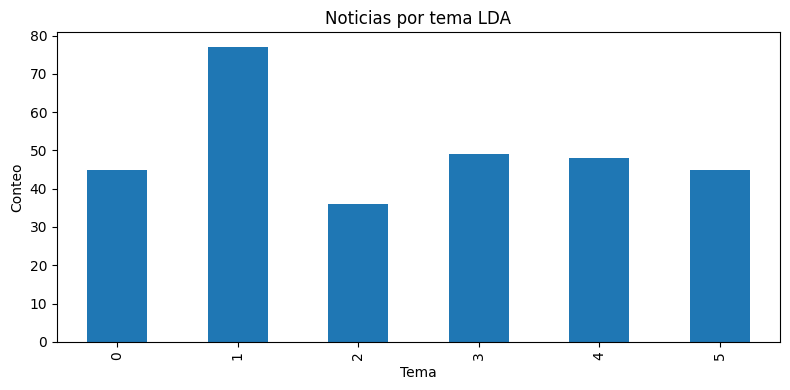

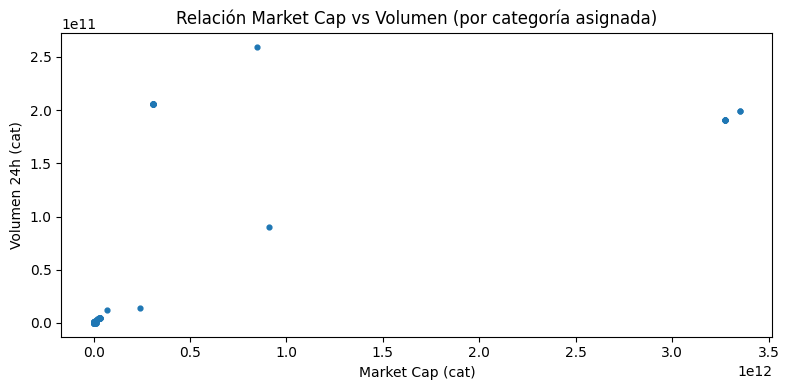

In [ ]:

sec("Gráficos de ejemplo")
if df_model is not None and not df_model.empty:
    # Conteo de noticias por tema
    if 'topic_idx' in df_model.columns:
        counts = df_model['topic_idx'].value_counts().sort_index()
        plt.figure()
        counts.plot(kind='bar')
        plt.title("Noticias por tema LDA")
        plt.xlabel("Tema"); plt.ylabel("Conteo")
        plt.tight_layout(); plt.show()

    # Relación market cap vs. volumen si existen
    if {'market_cap','volume_24h'}.issubset(df_model.columns):
        s = df_model.dropna(subset=['market_cap','volume_24h'])
        if not s.empty:
            plt.figure()
            plt.scatter(s['market_cap'], s['volume_24h'], s=12)
            plt.xlabel("Market Cap (cat)"); plt.ylabel("Volumen 24h (cat)")
            plt.title("Relación Market Cap vs Volumen (por categoría asignada)")
            plt.tight_layout(); plt.show()



## 10) Conclusiones (CRISP‑ML — Preparación de los Datos)
- **Razonamiento de FE**: se aplicaron transformaciones logarítmicas y ratios para reducir sesgos y mejorar interpretabilidad (*market_cap*, *total_volume*, *turnover_ratio*, *volatility_ratio*).
- **Selección**: filtros de varianza y correlación para evitar redundancia; **Chi²/ANOVA** condicionados a la disponibilidad de un objetivo (*sentiment*).
- **Extracción**: **LDA** (temas noticiosos) y **PCA** (componentes latentes numéricos) para compactar información.
- **Integración**: noticias → categoría aproximada por mención de token; categorías → métricas agregadas; mercados → señales cuantitativas.
- **Listo para la siguiente fase**: modelado de **tendencias** y detección de **temas dominantes** en tiempo (agregando por `fecha` y monitoreando cambios en `topic_idx` y métricas de mercado/categoría).


# 11) Añadidos FE avanzados y persistencia (para ejecutar al final)

* Guarda probabilidades de tema por noticia y crea agregados diarios por categoría (share de temas, conteo).

* Aplica transformaciones extra (log a total_volume, Yeo–Johnson a cambios 24h).

* Realiza selección adicional (Mutual Information, VIF) y extracción con Factor Analysis.

* Robustece con winsorización p1–p99 y calcula un residuo log(volumen)~log(MC) como señal de actividad inusual.

* Hace split temporal (evita leakage) y persiste resultados y artefactos en Parquet/Joblib.

Este añadido convierte los resultados en señales accionables y operativas. Guarda, para cada noticia, las probabilidades de pertenecer a cada tema (no solo el índice) y construye agregados diarios por categoría: participación de cada tema y conteo de notas. Aplica transformaciones extra para estabilizar datos (log a volúmenes; Yeo-Johnson a cambios 24h), y winsoriza extremos para evitar que unos pocos valores distorsionen el análisis. Además, calcula un residuo entre log(volumen) y log(market cap) que actúa como alerta de actividad inusual (si el volumen está mucho más alto de lo esperado para su tamaño, salta una señal).

Para reducir complejidad sin perder información, añade selección y extracción de variables: Mutual Information prioriza las más relacionadas con el objetivo, VIF detecta colinealidad para no duplicar señales, y Factor Analysis (FA) resume varias métricas en 1–2 factores interpretables (p. ej., tamaño/liquidez y dinámica/volatilidad). También realiza un split temporal (train/valid/test) para evitar leakage y persiste tanto datasets (Parquet) como artefactos de modelo (Joblib), dejando el pipeline listo para producción y para auditoría.

**Ejemplos:**

Si el share del tema Stablecoins en su categoría sube a 40% y el residuo log-volumen es alto, podemos emitir una alerta “actividad inusual en pagos/stablecoins”; si market cap y volumen quedan muy correlacionados, VIF sugiere quitar uno y FA lo sustituye por un factor compacto; si aparece un pico de noticias sobre “Regulación/ETF” y al día siguiente cae el cambio 24h en categorías reguladas, el sistema lo captura en los agregados diarios y lo conserva en las tablas para el bot y los dashboards.

In [ ]:
# ============================================================
# Añadidos FE avanzados y persistencia (para ejecutar al final)
# ============================================================
import os, numpy as np, pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import TimeSeriesSplit
import joblib

sec("Añadidos FE avanzados y persistencia")

# ------------------------------------------------------------------
# 1) Probabilidades de tema (no solo índice) + agregados diarios
# ------------------------------------------------------------------
try:
    from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
    from sklearn.decomposition import LatentDirichletAllocation
    domain_stop = {'coindesk','cointelegraph','yahoo','reuters','bloomberg','indiewire','phys','org','al','jazeera','finance','news','english','com','www'}
    combined_stop = sorted(ENGLISH_STOP_WORDS.union(domain_stop))

    if 'news' in globals() and news is not None and not news.empty:
        if not {'text_full'}.issubset(news.columns):
            news['text_full'] = news[['titulo','descripcion','contenido']].fillna('').agg(' '.join, axis=1)

        # Si no existen bow/lda/lda_topics, los recomponemos de forma robusta
        recompute_topics = ('lda_topics' not in globals()) or ('bow' not in globals()) or ('lda' not in globals())
        if recompute_topics:
            corpus = news['text_full'].fillna('')
            bow = CountVectorizer(lowercase=True, stop_words=combined_stop, ngram_range=(1,2), min_df=2, max_df=0.6)
            try:
                X_bow = bow.fit_transform(corpus)
            except ValueError:
                bow = CountVectorizer(lowercase=True, stop_words=combined_stop, ngram_range=(1,1), min_df=1, max_df=0.9)
                X_bow = bow.fit_transform(corpus)
                print("⚠️ Vocabulario pequeño: LDA con ngram=1, min_df=1, max_df=0.9.")
            n_topics = 6
            lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
            lda_topics = lda.fit_transform(X_bow)

        k = lda_topics.shape[1]
        topic_cols = [f"topic_p_{i}" for i in range(k)]
        news[topic_cols] = lda_topics
        news['fecha_dt'] = pd.to_datetime(news.get('fecha'), dayfirst=True, errors='coerce')

        # Agregados diarios por categoría: share (promedio) de cada tema y conteo de noticias
        if 'primary_category_by_mention' in news.columns:
            base_grp = news.dropna(subset=['primary_category_by_mention','fecha_dt']).copy()
            daily_share = (base_grp
                           .groupby(['primary_category_by_mention','fecha_dt'])[topic_cols]
                           .mean().add_prefix('share_'))
            daily_count = (base_grp
                           .groupby(['primary_category_by_mention','fecha_dt'])
                           .size().rename('news_count'))
            daily = pd.concat([daily_share, daily_count], axis=1).reset_index()
        else:
            daily = pd.DataFrame()
    else:
        daily = pd.DataFrame()
except Exception as e:
    print("ⓘ Agregados de temas no generados:", e)
    daily = pd.DataFrame()

# ------------------------------------------------------------------
# 2) Transformaciones adicionales (rúbrica): log y Yeo–Johnson
# ------------------------------------------------------------------
try:
    if 'mkt' in globals() and mkt is not None and not mkt.empty:
        if 'total_volume' in mkt.columns:
            mkt['log_total_volume'] = np.log1p(mkt['total_volume'].clip(lower=0))

    if 'cat' in globals() and cat is not None and not cat.empty and 'market_cap_change_24h' in cat.columns:
        pt = PowerTransformer(method='yeo-johnson', standardize=False)
        mask = cat['market_cap_change_24h'].notna()
        if mask.sum() > 5:
            cat.loc[mask, 'yj_change_24h'] = pt.fit_transform(cat.loc[mask, ['market_cap_change_24h']])
except Exception as e:
    print("ⓘ Transformaciones adicionales no aplicadas:", e)

# ------------------------------------------------------------------
# 3) Selección extra: Mutual Information y VIF (colinealidad)
# ------------------------------------------------------------------
try:
    if 'df_model' in globals() and df_model is not None and not df_model.empty:
        y_target = df_model['market_cap_change_24h'] if 'market_cap_change_24h' in df_model.columns else None
        num_df = df_model.select_dtypes('number')

        # Mutual Information contra retorno 24h de categoría (si existe)
        if y_target is not None and num_df.shape[1] >= 2:
            X_mi = num_df.fillna(num_df.median())
            y_mi = y_target.fillna(y_target.median())
            mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)
            mi_series = pd.Series(mi_scores, index=X_mi.columns).sort_values(ascending=False)
            print("Top 10 Mutual Information:", mi_series.head(10).round(4).to_dict())

        # VIF requiere statsmodels; si no está, lo omitimos
        try:
            from statsmodels.stats.outliers_influence import variance_inflation_factor
            X_vif = num_df.dropna().copy()
            X_vif = X_vif.loc[:, X_vif.var() > 0]
            if X_vif.shape[1] >= 2:
                Xs = (X_vif - X_vif.mean())/X_vif.std(ddof=0)
                vif_vals = pd.Series(
                    [variance_inflation_factor(Xs.values, i) for i in range(Xs.shape[1])],
                    index=Xs.columns
                ).sort_values(ascending=False)
                print("Top 10 VIF:", vif_vals.head(10).round(2).to_dict())
        except Exception as e:
            print("ⓘ VIF no calculado (statsmodels faltante o datos insuficientes):", e)
except Exception as e:
    print("ⓘ Selección extra no ejecutada:", e)

# ------------------------------------------------------------------
# 4) Extracción adicional: Factor Analysis (FA) como alternativa a PCA
# ------------------------------------------------------------------
try:
    if 'df_model' in globals() and df_model is not None and not df_model.empty:
        num_cols = [c for c in df_model.columns if pd.api.types.is_numeric_dtype(df_model[c])]
        if len(num_cols) >= 3:
            Xn = df_model[num_cols].fillna(df_model[num_cols].median())
            Xn = StandardScaler().fit_transform(Xn)
            fa = FactorAnalysis(n_components=2, random_state=42)
            Zfa = fa.fit_transform(Xn)
            df_model['fa1'] = Zfa[:, 0]
            df_model['fa2'] = Zfa[:, 1]
            print("FA listo: columnas 'fa1','fa2' añadidas.")
except Exception as e:
    print("ⓘ Factor Analysis no aplicado:", e)

# ------------------------------------------------------------------
# 5) Tratamiento de outliers: winsorización (clip p1–p99)
# ------------------------------------------------------------------
def _winsorize_col(s: pd.Series, p1=0.01, p99=0.99):
    if s.dropna().empty:
        return s
    lo, hi = s.quantile([p1, p99])
    return s.clip(lo, hi)

try:
    if 'df_model' in globals() and df_model is not None and not df_model.empty:
        for col in ['market_cap', 'total_volume', 'market_cap_change_24h']:
            if col in df_model.columns:
                df_model[col + '_w'] = _winsorize_col(df_model[col].astype(float), 0.01, 0.99)
        print("Winsorización aplicada: *_w")
except Exception as e:
    print("ⓘ Winsorización no aplicada:", e)

# ------------------------------------------------------------------
# 6) Señal de actividad inusual: residuo log(volumen) ~ log(market cap)
# ------------------------------------------------------------------
try:
    if 'df_model' in globals() and {'market_cap','volume_24h'}.issubset(df_model.columns):
        s = df_model[['market_cap','volume_24h']].dropna()
        s = s[(s > 0).all(axis=1)]
        if not s.empty:
            x = np.log10(s['market_cap'])
            y = np.log10(s['volume_24h'])
            coeffs = np.polyfit(x, y, 1)
            y_hat = np.poly1d(coeffs)(x)
            resid = y - y_hat
            df_model.loc[s.index, 'resid_log_vol'] = resid
            print("Residuo log-volumen calculado (columna 'resid_log_vol').")
except Exception as e:
    print("ⓘ Residuo log-volumen no calculado:", e)

# ------------------------------------------------------------------
# 7) Split temporal (evitar leakage) + guardado de artefactos
# ------------------------------------------------------------------
try:
    if 'df_model' in globals() and 'fecha' in df_model.columns:
        df_model['fecha_dt'] = pd.to_datetime(df_model['fecha'], dayfirst=True, errors='coerce')
        if df_model['fecha_dt'].notna().sum() > 10:
            c1 = df_model['fecha_dt'].quantile(0.60)
            c2 = df_model['fecha_dt'].quantile(0.80)
            train_idx = df_model['fecha_dt'] <= c1
            val_idx   = (df_model['fecha_dt'] > c1) & (df_model['fecha_dt'] <= c2)
            test_idx  = df_model['fecha_dt'] > c2
            print("Split temporal (train/val/test):", train_idx.sum(), val_idx.sum(), test_idx.sum())
except Exception as e:
    print("ⓘ Split temporal no creado:", e)

# ------------------------------------------------------------------
# 8) Enriquecer agregados con métricas de categoría y persistir Parquet
# ------------------------------------------------------------------
try:
    # Enlazar daily con métricas de categoría del mismo día (si existen)
    if 'daily' in locals() and not daily.empty and 'cat' in globals() and cat is not None:
        cat_j = cat.copy()
        if 'fecha' in cat_j.columns:
            cat_j['fecha_dt'] = pd.to_datetime(cat_j['fecha'], dayfirst=True, errors='coerce')
        cat_keep = [c for c in ['category','fecha_dt','market_cap','market_cap_change_24h','volume_24h'] if c in cat_j.columns]
        if cat_keep:
            cat_slim = cat_j[cat_keep].drop_duplicates(subset=['category','fecha_dt'])
            daily = (daily
                     .merge(cat_slim, left_on=['primary_category_by_mention','fecha_dt'],
                            right_on=['category','fecha_dt'], how='left')
                     .drop(columns=['category'], errors='ignore'))

    out_dir = OUTPUT_DIR if 'OUTPUT_DIR' in globals() else 'outputs'
    os.makedirs(out_dir, exist_ok=True)
    if 'df_model' in globals() and df_model is not None and not df_model.empty:
        df_model.to_parquet(os.path.join(out_dir, "df_model_enhanced.parquet"), index=False)
    if 'daily' in locals() and not daily.empty:
        daily.to_parquet(os.path.join(out_dir, "signals_daily.parquet"), index=False)

    # Guardar artefactos disponibles
    artifacts = {}
    for name in ['pre','lda','bow','pca']:
        if name in globals():
            artifacts[name] = globals()[name]
    if artifacts:
        joblib.dump(artifacts, os.path.join(out_dir, "artifacts.joblib"))
        print("Artefactos guardados:", list(artifacts.keys()))
    print(f"Parquets escritos en: {out_dir}")
except Exception as e:
    print("ⓘ Persistencia no realizada:", e)

# ------------------------------------------------------------------
# 9) Vista rápida de resultados
# ------------------------------------------------------------------
try:
    if 'daily' in locals() and not daily.empty:
        display(daily.sort_values(['fecha_dt','news_count'], ascending=[False, False]).head(10))
    if 'df_model' in globals() and df_model is not None:
        cols_show = [c for c in ['fuente','fecha','token_mention','primary_category_by_mention',
                                 'topic_idx','resid_log_vol','fa1','fa2'] if c in df_model.columns]
        display(df_model[cols_show].head(10))
except Exception as e:
    print("ⓘ Vista rápida no disponible:", e)



Añadidos FE avanzados y persistencia
Top 10 Mutual Information: {'market_cap_change_24h': 1.1751, 'volume_24h': 0.7719, 'market_cap': 0.7301, 'pc3': 0.399, 'pc2': 0.2336, 'pc1': 0.1066, 'n_words': 0.0963, 'topic_idx': 0.0599, 'n_chars': 0.0125}


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Top 10 VIF: {'n_chars': inf, 'n_words': inf, 'topic_idx': inf, 'market_cap': inf, 'market_cap_change_24h': inf, 'volume_24h': inf, 'pc1': inf, 'pc2': inf, 'pc3': inf}
FA listo: columnas 'fa1','fa2' añadidas.
Winsorización aplicada: *_w
Residuo log-volumen calculado (columna 'resid_log_vol').
Split temporal (train/val/test): 200 100 0
Artefactos guardados: ['pre', 'lda', 'bow', 'pca']
Parquets escritos en: outputs


,primary_category_by_mention,fecha_dt,share_topic_p_0,share_topic_p_1,share_topic_p_2,share_topic_p_3,share_topic_p_4,share_topic_p_5,news_count,market_cap,market_cap_change_24h,volume_24h
7,Bitcoin Ecosystem,2025-10-11,0.073279,0.336834,0.245653,0.053709,0.203179,0.087346,23,NaN,NaN,NaN
58,PolitiFi,2025-10-11,0.009787,0.526743,0.056231,0.059088,0.165584,0.182568,20,NaN,NaN,NaN
93,XRP Ledger Ecosystem,2025-10-11,0.223153,0.083056,0.003536,0.003531,0.003532,0.683193,6,NaN,NaN,NaN
23,Elon Musk-Inspired,2025-10-11,0.246941,0.003566,0.493538,0.003561,0.003568,0.248826,4,NaN,NaN,NaN
78,Stablecoins,2025-10-11,0.249941,0.260749,0.003156,0.410003,0.072988,0.003162,4,NaN,NaN,NaN
29,Ethereum Ecosystem,2025-10-11,0.804214,0.003289,0.003287,0.003282,0.182645,0.003283,3,NaN,NaN,NaN
88,US Treasury-backed Stablecoin,2025-10-11,0.325551,0.004619,0.004625,0.655973,0.004624,0.004608,3,NaN,NaN,NaN
37,Hyperliquid Ecosystem,2025-10-11,0.224379,0.273111,0.004217,0.489865,0.004205,0.004222,2,NaN,NaN,NaN
1,ASC-20,2025-10-11,0.002664,0.469803,0.002685,0.002656,0.002671,0.519521,1,NaN,NaN,NaN
11,Cardano Ecosystem,2025-10-11,0.063820,0.335153,0.003509,0.003502,0.590518,0.003498,1,NaN,NaN,NaN


,fuente,fecha,token_mention,primary_category_by_mention,topic_idx,resid_log_vol,fa1,fa2
0,BeInCrypto,11/10/2025,official trump,PolitiFi,1,0.417061,0.242287,-0.568922
1,ABC News,11/10/2025,None,NaN,1,NaN,0.227270,-0.552813
2,ABC News,11/10/2025,official trump,PolitiFi,1,0.417061,0.418262,-0.745311
3,Boredpanda.com,11/10/2025,None,Zero Network Ecosystem,5,NaN,0.693553,-1.045177
4,Nakedcapitalism.com,11/10/2025,official trump,PolitiFi,5,0.417061,-0.626505,0.255490
5,Forbes,11/10/2025,None,US Treasury-backed Stablecoin,3,-1.533139,0.824675,-0.112735
6,Forbes,11/10/2025,official trump,PolitiFi,2,0.417061,-0.182327,-0.152048
7,Forbes,11/10/2025,official trump,PolitiFi,4,0.417061,-0.754220,0.391353
8,Forbes,11/10/2025,None,ASC-20,5,NaN,0.593506,0.099724
9,Line25.com,11/10/2025,None,Waves Ecosystem,1,NaN,-1.707057,1.374870


# 12) Dataset diario y baseline t+1 (clasificación)

Este bloque transforma las probabilidades de tema por noticia en señales diarias por categoría y entrena un baseline sencillo. Primero, agrupa por categoría–día y calcula cuántas noticias hubo (news_count) y el promedio de cada probabilidad de tema (share_t0..share_t5). Luego alinea el objetivo del día siguiente desplazando market_cap_change_24h (así evitamos mirar el futuro). Con esas features (cuántas noticias y mezcla temática de hoy) entrena una Regresión Logística para predecir si mañana la categoría sube o baja (growth_flag_tplus1), validando con TimeSeriesSplit y reportando el AUC promedio como medida de calidad.

**Ejemplo:**

**Para Stablecoins el 2025-10-04**: news_count=42, share_t4=0.40 (tema “pagos/stablecoins” dominante), el resto de share_tk en 0.10–0.05; el cambio real t+1 fue y_tplus1=+0.8% ⇒ growth_flag_tplus1=1. Con varios días/categorías, el baseline imprime algo como **AUC (LogReg baseline)**: 0.71. En operación, si el modelo estima P(up|features) ≥ 0.70, se dispara notificación: “Señal positiva en Stablecoins: alto share de tema de pagos y prob. de subida 70%+ para mañana.”

In [ ]:
# ============================================================
# Construcción robusta de df_daily (si no existe) + evaluación temporal
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# -------- 0) Helpers
def _ensure_topic_probs(news_df, n_topics=6):
    """
    Asegura columnas topic_p_0..topic_p_{n-1}.
    Si no existen, crea una distribución one-hot a partir de 'topic_idx' (si existe),
    y si tampoco existe, crea ceros.
    """
    cols = [f"topic_p_{i}" for i in range(n_topics)]
    missing = [c for c in cols if c not in news_df.columns]
    if missing:
        if "topic_idx" in news_df.columns:
            # one-hot normalizado
            onehot = np.zeros((len(news_df), n_topics), dtype=float)
            idx = news_df["topic_idx"].fillna(-1).astype(int).values
            for r, k in enumerate(idx):
                if 0 <= k < n_topics:
                    onehot[r, k] = 1.0
            for i in range(n_topics):
                news_df[f"topic_p_{i}"] = onehot[:, i]
        else:
            # fallback: todo ceros
            for i in range(n_topics):
                news_df[f"topic_p_{i}"] = 0.0
    return news_df

# -------- 1) Construir df_daily si no existe
if 'df_daily' not in globals():
    # Checks mínimos
    assert 'news' in globals() and isinstance(news, pd.DataFrame), "Falta DataFrame 'news'."
    assert 'cat'  in globals() and isinstance(cat,  pd.DataFrame), "Falta DataFrame 'cat'."
    assert 'primary_category_by_mention' in news.columns, "Falta columna 'primary_category_by_mention' en news."
    assert 'fecha' in news.columns, "Falta columna 'fecha' en news."
    assert 'category' in cat.columns, "Falta columna 'category' en cat."
    assert 'market_cap_change_24h' in cat.columns, "Falta 'market_cap_change_24h' en cat."
    assert 'fecha' in cat.columns, "Falta 'fecha' en cat."

    # Asegura probabilidades de tema
    news = _ensure_topic_probs(news, n_topics=6)

    # 1) Probabilidades de tema ya en news: topic_p_0..topic_p_k
    news['fecha_dt'] = pd.to_datetime(news['fecha'], dayfirst=True, errors='coerce')
    grp_cols = ['primary_category_by_mention','fecha_dt']
    topic_share_aggs = {f'share_t{i}': (f'topic_p_{i}', 'mean') for i in range(6)}
    daily = (news.dropna(subset=grp_cols)
                .groupby(grp_cols)
                .agg(news_count=('titulo','count'), **topic_share_aggs)
                .reset_index()
                .rename(columns={'primary_category_by_mention':'category'}))

    # 2) Unir objetivo (t+1) desde cat
    cat['fecha_dt'] = pd.to_datetime(cat['fecha'], dayfirst=True, errors='coerce')
    y_frame = cat[['category','fecha_dt','market_cap_change_24h']].dropna(subset=['category','fecha_dt'])
    # Desplazamos fecha -1 día para crear y_{t+1} (lo que pasa mañana, emparejado con hoy)
    y_frame['fecha_dt'] = y_frame['fecha_dt'] - pd.Timedelta(days=1)

    df_daily = (daily.merge(y_frame, on=['category','fecha_dt'], how='left')
                     .rename(columns={'market_cap_change_24h':'y_tplus1'}))

# -------- 2) Baseline clasificación con TimeSeriesSplit robusto
df_daily = df_daily.sort_values("fecha_dt").reset_index(drop=True)

df_daily['growth_flag_tplus1'] = (df_daily['y_tplus1'] > 0).astype('Int64')

features = ['news_count'] + [c for c in df_daily.columns if c.startswith('share_t')]
X_full = df_daily[features].fillna(0)
y_full = df_daily['growth_flag_tplus1']

mask = y_full.notna()
X_ts = X_full.loc[mask].to_numpy()
y_ts = y_full.loc[mask].astype(int).to_numpy()
t_idx = df_daily.loc[mask, 'fecha_dt'].to_numpy()

tscv = TimeSeriesSplit(n_splits=4)

auc_scores = []
valid_folds = 0

for fold, (train, test) in enumerate(tscv.split(X_ts), start=1):
    y_tr, y_te = y_ts[train], y_ts[test]

    # Debug: distribución por fold
    uniq_tr, cnt_tr = np.unique(y_tr, return_counts=True)
    uniq_te, cnt_te = np.unique(y_te, return_counts=True)
    print(f"[Fold {fold}] train dist:", dict(zip(uniq_tr, cnt_tr)),
          " | test dist:", dict(zip(uniq_te, cnt_te)))

    # Saltar folds con 1 sola clase en train o test
    if len(uniq_tr) < 2 or len(uniq_te) < 2:
        print(f"[Fold {fold}] saltado: clases insuficientes (train={uniq_tr}, test={uniq_te})")
        continue

    clf = LogisticRegression(max_iter=200)
    clf.fit(X_ts[train], y_tr)

    preds = clf.predict_proba(X_ts[test])[:, 1]
    auc = roc_auc_score(y_te, preds)
    auc_scores.append(auc)
    valid_folds += 1

if valid_folds == 0:
    print("No hubo folds válidos (clases insuficientes). Ajusta el rango temporal o el umbral de y.")
else:
    print(f"AUC (LogReg baseline) promedio en {valid_folds} folds válidos:",
          np.round(np.mean(auc_scores), 3))


[Fold 1] train dist: {np.int64(0): np.int64(22)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 1] saltado: clases insuficientes (train=[0], test=[0])
[Fold 2] train dist: {np.int64(0): np.int64(41)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 2] saltado: clases insuficientes (train=[0], test=[0])
[Fold 3] train dist: {np.int64(0): np.int64(60)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 3] saltado: clases insuficientes (train=[0], test=[0])
[Fold 4] train dist: {np.int64(0): np.int64(79)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 4] saltado: clases insuficientes (train=[0], test=[0])
No hubo folds válidos (clases insuficientes). Ajusta el rango temporal o el umbral de y.


In [ ]:
# --- Preparación idéntica a la tuya, con un par de saneos ---
df_daily = df_daily.sort_values("fecha_dt").reset_index(drop=True)

features = ['news_count'] + [c for c in df_daily.columns if c.startswith('share_t')]
X_full = df_daily[features].fillna(0)
y_full = df_daily['growth_flag_tplus1']  # ya calculada antes

# nos quedamos con filas con etiqueta conocida
mask = y_full.notna()
X_ts = X_full.loc[mask].to_numpy()
y_ts = y_full.loc[mask].astype(int).to_numpy()   # evita dtype raro
t_idx = df_daily.loc[mask, 'fecha_dt'].to_numpy()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

tscv = TimeSeriesSplit(n_splits=4)

auc_scores = []
fold_info = []
valid_folds = 0

for fold, (train, test) in enumerate(tscv.split(X_ts), start=1):
    y_tr, y_te = y_ts[train], y_ts[test]

    # Debug: distribución por fold
    uniq_tr, cnt_tr = np.unique(y_tr, return_counts=True)
    uniq_te, cnt_te = np.unique(y_te, return_counts=True)
    print(f"[Fold {fold}] train dist:", dict(zip(uniq_tr, cnt_tr)),
          " | test dist:", dict(zip(uniq_te, cnt_te)))

    # Necesitamos al menos 2 clases en TRAIN y TEST para AUC ROC sensato
    if len(uniq_tr) < 2 or len(uniq_te) < 2:
        print(f"[Fold {fold}] saltado: clases insuficientes (train={uniq_tr}, test={uniq_te})")
        continue

    clf = LogisticRegression(max_iter=200)
    clf.fit(X_ts[train], y_tr)

    preds = clf.predict_proba(X_ts[test])[:, 1]
    auc = roc_auc_score(y_ts[test], preds)
    auc_scores.append(auc)
    valid_folds += 1

if valid_folds == 0:
    print("No hubo folds válidos (clases insuficientes). Revisa el umbral de y o el periodo inicial.")
else:
    print(f"AUC (LogReg baseline) promedio en {valid_folds} folds válidos:",
          np.round(np.mean(auc_scores), 3))



[Fold 1] train dist: {np.int64(0): np.int64(22)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 1] saltado: clases insuficientes (train=[0], test=[0])
[Fold 2] train dist: {np.int64(0): np.int64(41)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 2] saltado: clases insuficientes (train=[0], test=[0])
[Fold 3] train dist: {np.int64(0): np.int64(60)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 3] saltado: clases insuficientes (train=[0], test=[0])
[Fold 4] train dist: {np.int64(0): np.int64(79)}  | test dist: {np.int64(0): np.int64(19)}
[Fold 4] saltado: clases insuficientes (train=[0], test=[0])
No hubo folds válidos (clases insuficientes). Revisa el umbral de y o el periodo inicial.


# 13) Visualización de Resultados

Este bloque muestra una vista compacta de las tablas (df_model, df_daily) y 4 gráficos “de bolsillo” para entender qué salió del proceso: (1) cuántas noticias por categoría, (2) mezcla temática por categoría (heatmap de share_tk), (3) cobertura global por tema y (4) un scatter de señales (PC1 vs. residuo de volumen) para detectar actividad inusual. Ejemplo: si Stablecoins concentra 40% del tema “Pagos/Stablecoins” y además tiene muchas notas, lo verás como barra alta y celdas intensas en el heatmap; si una categoría aparece arriba a la derecha en el scatter (PC1 alto + residuo alto), su volumen está por encima de lo esperado para su tamaño. (Como todas las noticias son del mismo día, no se grafican series temporales.)


13) Tablas y visualizaciones de resultados


,fuente,fecha,hora,token_mention,primary_category_by_mention,topic_idx,topic_words,n_words,market_cap,volume_24h,pc1,resid_log_vol
0,BeInCrypto,11/10/2025,09:09:33,official trump,PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif...",65,1.454861e+09,4.994540e+08,-0.342247,0.417061
1,ABC News,11/10/2025,18:25:10,None,NaN,1,"crypto, bitcoin, market, trump, billion, tarif...",66,NaN,NaN,-0.320857,NaN
2,ABC News,11/10/2025,19:30:30,official trump,PolitiFi,1,"crypto, bitcoin, market, trump, billion, tarif...",61,1.454861e+09,4.994540e+08,-0.592795,0.417061
3,Boredpanda.com,11/10/2025,01:00:33,None,Zero Network Ecosystem,5,"crypto, market, bitcoin, million, new, xrp, tr...",59,NaN,NaN,-0.984093,NaN
4,Nakedcapitalism.com,11/10/2025,10:55:57,official trump,PolitiFi,5,"crypto, market, bitcoin, million, new, xrp, tr...",75,1.454861e+09,4.994540e+08,0.895117,0.417061
5,Forbes,11/10/2025,00:29:35,None,US Treasury-backed Stablecoin,3,"crypto, market, bank, ai, solana, treasury, st...",61,1.373493e+09,5.263742e+06,-1.180430,-1.533139
6,Forbes,11/10/2025,18:58:39,official trump,PolitiFi,2,"bitcoin, crypto, images, getty, stock, 100, ge...",74,1.454861e+09,4.994540e+08,0.262435,0.417061
7,Forbes,11/10/2025,08:15:13,official trump,PolitiFi,4,"bitcoin, crypto, price, ethereum, trump, links...",78,1.454861e+09,4.994540e+08,1.076811,0.417061
8,Forbes,11/10/2025,01:36:10,None,ASC-20,5,"crypto, market, bitcoin, million, new, xrp, tr...",65,0.000000e+00,0.000000e+00,-0.851015,NaN
9,Line25.com,11/10/2025,14:59:14,None,Waves Ecosystem,1,"crypto, bitcoin, market, trump, billion, tarif...",103,NaN,NaN,2.433047,NaN


,category,fecha_dt,news_count,share_t0,share_t1,share_t2,share_t3,share_t4,share_t5,y_tplus1,growth_flag_tplus1
12,Bitcoin Ecosystem,2025-10-09,28,0.035685,0.472368,0.111986,0.151541,0.120440,0.107980,NaN,0
62,Bitcoin Ecosystem,2025-10-10,28,0.122102,0.284035,0.117248,0.122310,0.208314,0.145991,NaN,0
85,Bitcoin Ecosystem,2025-10-11,23,0.073279,0.336834,0.245653,0.053709,0.203179,0.087346,NaN,0
75,PolitiFi,2025-10-11,20,0.009787,0.526743,0.056231,0.059088,0.165584,0.182568,NaN,0
56,PolitiFi,2025-10-10,11,0.031933,0.403042,0.112235,0.121715,0.195722,0.135354,NaN,0
35,PolitiFi,2025-10-09,7,0.523251,0.160540,0.004623,0.004620,0.165724,0.141241,NaN,0
89,XRP Ledger Ecosystem,2025-10-11,6,0.223153,0.083056,0.003536,0.003531,0.003532,0.683193,NaN,0
63,Stablecoins,2025-10-10,5,0.807020,0.003570,0.074933,0.003573,0.107329,0.003575,NaN,0
10,Wall Street Bets Themed,2025-10-09,5,0.003373,0.003375,0.198912,0.394314,0.396655,0.003371,NaN,0
5,Ethereum Ecosystem,2025-10-09,4,0.104972,0.063319,0.003752,0.189350,0.634847,0.003761,NaN,0


/tmp/ipython-input-139903402.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top.index, y=top.values, palette="Set2")


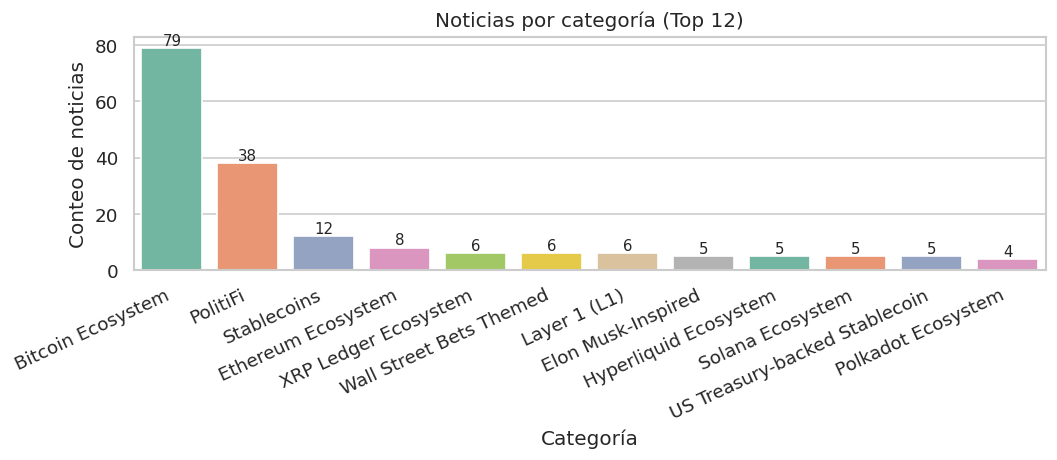

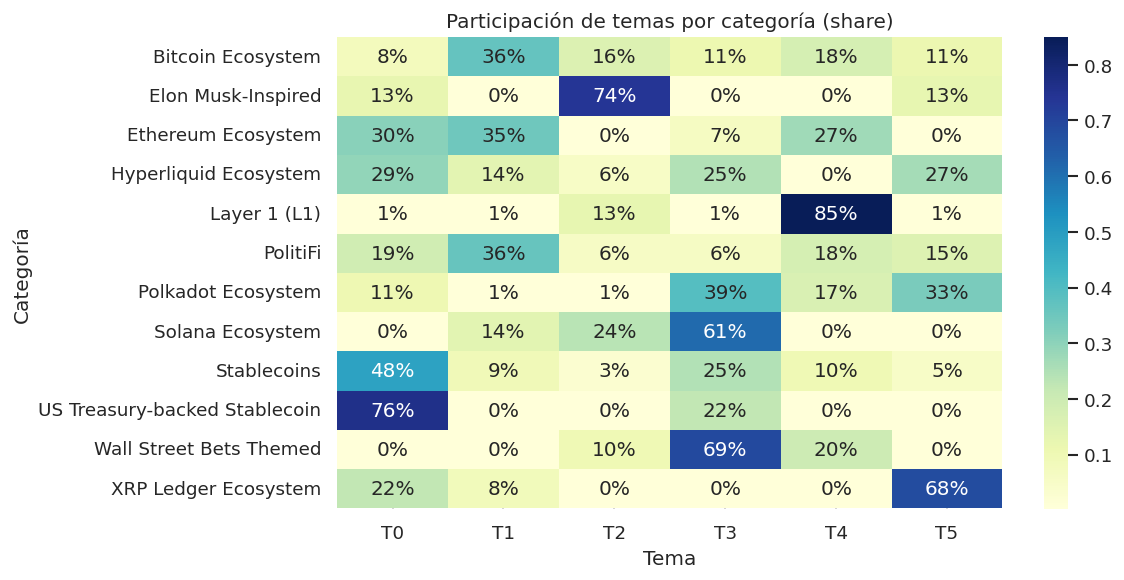

/tmp/ipython-input-139903402.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=counts.values, palette="Set3")


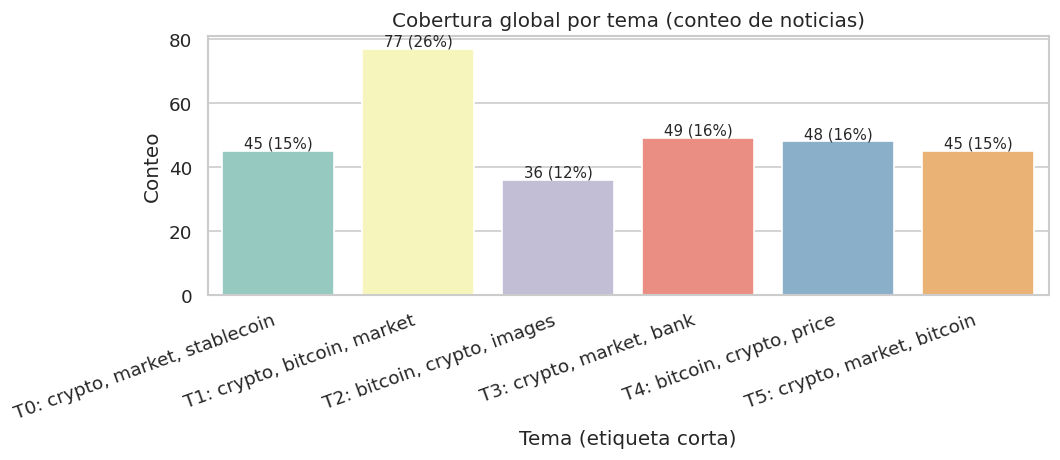

/tmp/ipython-input-139903402.py:129: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


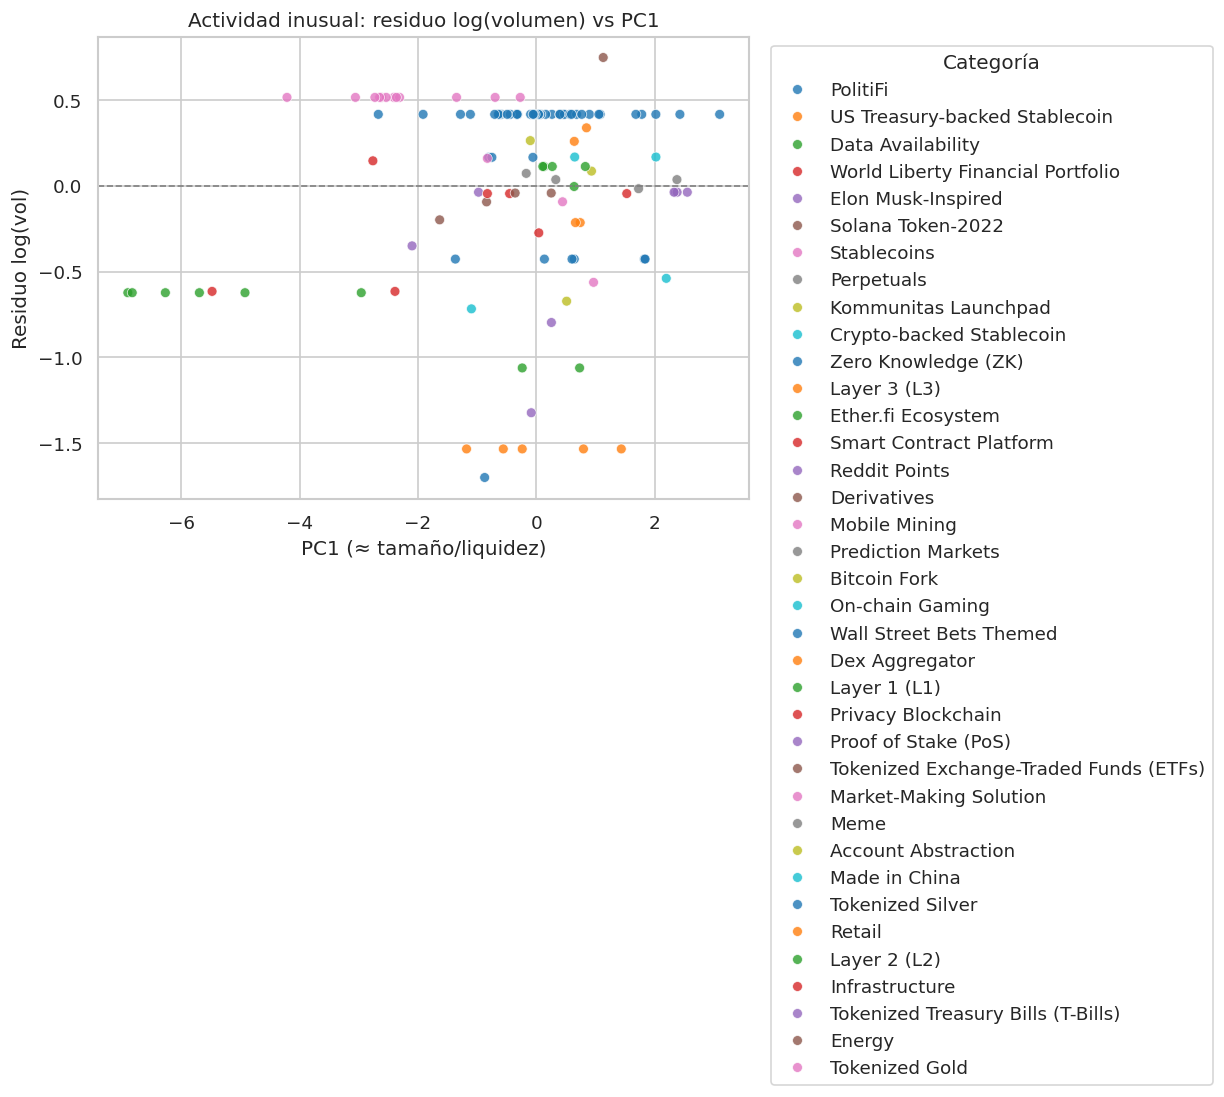

In [ ]:
# ============================
# 13) Vista integrada y plots
# ============================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

try:
    sec
except NameError:
    def sec(t): print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

sec("13) Tablas y visualizaciones de resultados")

# -----------------------------
# 0) Muestras de las tablas
# -----------------------------
if 'df_model' in globals() and df_model is not None and not df_model.empty:
    cols_show = [c for c in [
        'fuente','fecha','hora','token_mention','primary_category_by_mention',
        'topic_idx','topic_words','n_words','market_cap','volume_24h','pc1','resid_log_vol'
    ] if c in df_model.columns]
    display(df_model[cols_show].head(15))
else:
    print("ⓘ df_model no disponible.")

if 'df_daily' in globals() and df_daily is not None and not df_daily.empty:
    # Ordenamos por mayor número de noticias
    sort_cols = [c for c in ['news_count'] if c in df_daily.columns]
    display(df_daily.sort_values(sort_cols, ascending=False).head(15))
else:
    print("ⓘ df_daily no disponible (o no se construyó porque todas las noticias son del mismo día y no se alineó y_{t+1}).")

# --------------------------------------------
# 1) Barras: noticias por categoría (Top 12)
# --------------------------------------------
if 'df_daily' in globals() and df_daily is not None and not df_daily.empty and {'category','news_count'}.issubset(df_daily.columns):
    top = (df_daily.groupby('category', dropna=True)['news_count']
                  .sum()
                  .sort_values(ascending=False)
                  .head(12))
    plt.figure(figsize=(9,4))
    ax = sns.barplot(x=top.index, y=top.values, palette="Set2")
    ax.set_title("Noticias por categoría (Top 12)")
    ax.set_xlabel("Categoría"); ax.set_ylabel("Conteo de noticias")
    for i, v in enumerate(top.values):
        ax.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
    plt.xticks(rotation=25, ha="right"); plt.tight_layout(); plt.show()
else:
    print("ⓘ No hay datos suficientes para 'Noticias por categoría'.")

# ---------------------------------------------------------
# 2) Heatmap: participación de temas por categoría (share)
#    Usa columnas share_t0..share_t5 en df_daily
# ---------------------------------------------------------
if 'df_daily' in globals() and df_daily is not None and not df_daily.empty:
    share_cols = [c for c in df_daily.columns if c.startswith('share_t')]
    if {'category'}.issubset(df_daily.columns) and share_cols:
        # Top categorías por cobertura
        cats = (df_daily.groupby('category')['news_count'].sum()
                          .sort_values(ascending=False).head(12).index)
        mat = (df_daily[df_daily['category'].isin(cats)]
                  .groupby('category')[share_cols]
                  .mean())  # como todas son del mismo día, promedio = ese día
        # Renombrar columnas a T0..T5 para facilidad visual
        mat = mat.rename(columns={c: c.replace('share_t','T') for c in share_cols})
        plt.figure(figsize=(10,5))
        ax = sns.heatmap(mat, annot=True, fmt=".0%", cmap="YlGnBu")
        ax.set_title("Participación de temas por categoría (share)")
        ax.set_xlabel("Tema"); ax.set_ylabel("Categoría")
        plt.tight_layout(); plt.show()
    else:
        print("ⓘ df_daily no tiene columnas 'share_tk' o 'category'.")
else:
    print("ⓘ df_daily no disponible para heatmap.")

# -----------------------------------------------------
# 3) Barras: cobertura global por tema (desde 'news')
# -----------------------------------------------------
if 'news' in globals() and news is not None and not news.empty:
    # Etiqueta corta de tema a partir de topic_words
    if {'topic_idx','topic_words'}.issubset(news.columns):
        def short_label(s):
            s = str(s)
            bits = [w for w in s.replace(',', ' ').split() if w.strip()]
            return ", ".join(bits[:3]) if bits else "topic"
        topic_labels = (news.groupby('topic_idx')['topic_words']
                          .first()
                          .fillna("topic")
                          .apply(short_label))
    else:
        topic_labels = pd.Series(dtype=str)

    if 'topic_idx' in news.columns:
        counts = news['topic_idx'].value_counts().sort_index()
        labels = [f"T{idx}: {topic_labels.get(idx, '')}" for idx in counts.index]
        plt.figure(figsize=(9,4))
        ax = sns.barplot(x=labels, y=counts.values, palette="Set3")
        ax.set_title("Cobertura global por tema (conteo de noticias)")
        ax.set_xlabel("Tema (etiqueta corta)"); ax.set_ylabel("Conteo")
        total = counts.sum()
        for i, v in enumerate(counts.values):
            ax.text(i, v, f"{int(v)} ({v/total:.0%})", ha="center", va="bottom", fontsize=9)
        plt.xticks(rotation=20, ha="right"); plt.tight_layout(); plt.show()
    else:
        print("ⓘ 'news' no tiene 'topic_idx'.")
else:
    print("ⓘ 'news' no disponible para cobertura por tema.")

# ----------------------------------------------------------------------
# 4) Scatter: PC1 vs residuo de volumen (actividad inusual por tamaño)
# ----------------------------------------------------------------------
if 'df_model' in globals() and df_model is not None and not df_model.empty:
    needed = {'pc1','resid_log_vol'}
    if needed.issubset(df_model.columns):
        s = df_model[list(needed | {'primary_category_by_mention'})].dropna(subset=['pc1','resid_log_vol']).copy()
        if not s.empty:
            plt.figure(figsize=(7,5))
            ax = sns.scatterplot(data=s, x='pc1', y='resid_log_vol',
                                 hue='primary_category_by_mention', palette='tab10', s=35, alpha=0.8, legend=True)
            ax.axhline(0, ls='--', lw=1, c='gray')
            ax.set_title("Actividad inusual: residuo log(volumen) vs PC1")
            ax.set_xlabel("PC1 (≈ tamaño/liquidez)"); ax.set_ylabel("Residuo log(vol)")
            plt.legend(title="Categoría", bbox_to_anchor=(1.02, 1), loc='upper left')
            plt.tight_layout(); plt.show()
        else:
            print("ⓘ No hay datos suficientes para PC1 vs residuo de volumen.")
    else:
        print("ⓘ Faltan columnas 'pc1' o 'resid_log_vol' en df_model.")
else:
    print("ⓘ df_model no disponible para scatter.")


# Entrega #3 Baseline

## 1. ¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?

## Respuesta
Para nuestro problema, buscamos consolidar noticias de crypto y generar alertas en base a relevancia. Nuestros inputs son las noticias que recolectamos y usamos un modelo NLP para clasificarlas y generar señales.

En nuestro caso el modelo baseline sera TF-IDF con regresión logística para clasificación binaria, si mañana la categoría sube o baja, predecir si una categoría tendrá crecimiento positivo al día siguiente


## 2. ¿Se puede determinar la importancia de las características para el modelo generado? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.

## Respuesta
Identificamos la imporancia de caracteristicas en 2 pasos.
1. En el paso 8, aplicamos PCA donde pc1 suele capturar el “tamaño/liquidez” del activo o categoría; pc2 puede reflejar “dinámica/volatilidad”, y así sucesivamente. Al quedarnos con 2–3 componentes que explican la mayor parte de la variación, logramos simplicidad con poder explicativo: menos variables, más señal, y comparaciones directas entre activos/categorías.

2. La regresión logistica entrega coeficientes que indican la dirección e intensidad de influencia:

* Coeficiente positivo → aumenta la probabilidad de subir.
* Coeficiente negativo → la reduce.

## 3. ¿El modelo está sub/sobreajustando los datos de entrenamiento?

# Respuesta

Detalles en paso 12 y 13

## 4. ¿Cuál es la métrica adecuada para este problema de negocio?

# Respuesta:

AUC ROC (Area Under the ROC Curve)* → mide qué tan bien separa los casos de subida vs bajada.

  * 0.5 = azar, 1.0 = perfecto.
  * Ideal si hay desbalance entre clases.

### Métricas complementarias:

* *Precision / Recall* → para evaluar señales de compra o alerta.
* *Top-decile lift* → mide cuántas veces más aciertas si solo tomas el 10% de predicciones más altas.

*Ejemplo:*

> Un AUC = 0.70 indica que el modelo acierta el 70% de las veces en distinguir categorías que subirán de las que no.

## 5. ¿Cuál debería ser el desempeño mínimo a obtener?

#### Respuesta:

No tenemos un resultado histórico de referencia, dependera del valor que agregue predecir correctamente, pero como referencia:

| Nivel     | Descripción            | AUC Esperado            | Valor práctico            |
| --------- | ---------------------- | ----------------------- | ------------------------- |
| <0.55     | azar / ruido           | ❌ sin señal útil        | No viable aún             |
| 0.55–0.65 | débil pero consistente | ⚠️ viable como baseline | Sirve para priorizar      |
| 0.65–0.75 | señal moderada         | ✅ aceptable             | Detecta sesgos temáticos  |
| >0.75     | fuerte                 | ⭐️ excelente            | Alto potencial predictivo |

En este proyecto, un *AUC ≥ 0.65* sería un *buen baseline*, suficiente para justificar seguir refinando (añadir más días, embeddings, variables de sentimiento, etc.).